### __Import data__

In [1]:
import pandas as pd
import glob
import re
from itertools import compress

# chamber data
filelist = glob.glob('*.csv')
VeroMoatIdx = ['VeroMoat' in i for i in filelist]
#ii = 0
Vero = pd.DataFrame()
for ii in range(len(list(compress(filelist, VeroMoatIdx)))):    
    Vero = Vero.append(pd.read_csv(list(compress(filelist, VeroMoatIdx))[ii])) # intertools.compress to apply logical index on list
    
#Vero.head()
Vero.set_index(pd.to_datetime(Vero['Date']), inplace=True)
Vero = Vero.replace({'AST20': 'AST_Treat_20', 'AST23': 'AST_Treat_23', 'AST27': 'AST_Treat_27'}) #sort table by IDs for correct legendorder in plot
Vero.sort_values(by=['ID'], inplace=True)
#Vero = Vero.drop('Date', 'columns') # needed for plotting, could be impoved
#Vero = Vero.sort_index() # sort by id instead, temp assignment seems dynamic enough, doesnt need continuous timestamp

# 30 min biomet > 20180517
Biomet = pd.read_csv('Biomet30min_201805171830_to_201908301500.dat')
Biomet_units = list(Biomet.iloc[0])
Biomet = Biomet.drop([0 ,1], 'index') # drop text rows
Biomet.set_index(pd.to_datetime(Biomet.TIMESTAMP, format='%Y-%m-%d %H:%M:%S'), inplace=True)
Biomet = Biomet.drop('TIMESTAMP', 'columns')
Biomet.drop(columns='BattV_Avg', inplace=True)
Biomet = Biomet.astype('float') # set all dtypes to float, dtypes were messed up from text in rows dropped above 
Biomet = Biomet.drop('RECORD', 'columns')

#Biomet.head()

# 1 min biomet > 20180517
Biomet_1min = pd.read_csv('Biomet1min_201805171810_to_201908301640.dat', low_memory=False) # low_memory =False prevents warning about different data types in columns 
Biomet_1min_units = list(Biomet.iloc[0])
Biomet_1min = Biomet_1min.drop([0 ,1], 'index')
Biomet_1min.set_index(pd.to_datetime(Biomet_1min.TIMESTAMP, format='%Y-%m-%d %H:%M:%S'), inplace=True)
Biomet_1min = Biomet_1min.drop('TIMESTAMP', 'columns')
Biomet_1min = Biomet_1min.astype('float') 
Biomet_1min = Biomet_1min.drop('RECORD', 'columns')

# different file than in version 5, same header, easier to sync
# 30 min biomet < 20180517
from datetime import timedelta
AR_TF1 = pd.read_csv('Moat_Biomet.csv', encoding='latin', low_memory=False)


AR_TF1.set_index(
    pd.to_datetime(
        AR_TF1['Timestamp'],
        format='%d-%b-%Y %H:%M:%S') + 
        timedelta(minutes=15),
        inplace=True)

AR_TF1 = AR_TF1.drop('Timestamp', 'columns')
#AR_TF1 = AR_TF1.astype('float') # fix mixed dtype due to more than one header line on import
#AR_TF1.tail()

#AR_TF1


In [2]:
Vero

,ID,Date,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1
Date,,,,,,
2018-01-23 19:23:28,AST1P1,23-Jan-2018 19:23:28,-9.2272,1.48210,457.5705,37.5160
2018-03-07 16:59:17,AST1P1,07-Mar-2018 16:59:17,-6.4570,0.94889,1035.4533,18.9374
2018-03-07 17:04:04,AST1P1,07-Mar-2018 17:04:04,-5.9518,0.86008,1083.4106,27.3755
2018-03-07 17:08:59,AST1P1,07-Mar-2018 17:08:59,-6.2376,0.91240,1038.3606,52.7387
2018-03-07 17:16:26,AST1P1,07-Mar-2018 17:16:26,-6.6604,0.98303,1068.9876,22.8582
...,...,...,...,...,...,...
2019-01-18 18:58:29,SPH3P3,18-Jan-2019 18:58:29,1.4522,0.35604,2.7473,6.1431
2019-01-18 18:28:58,SPH3P3,18-Jan-2019 18:28:58,-3.3655,0.53736,1184.5325,77.7921
2019-01-18 18:35:59,SPH3P3,18-Jan-2019 18:35:59,-3.0945,0.49870,1144.0790,23.0360


### __exclude fluxes after visual inspection of conc vs time plots__

In [3]:
# from visual inspection
exclude = ['AST20 15:59:11',
           'AST20 16:05:08',
           'AST20 16:11:59',
           'AST20 16:18:58',
           'AST20 16:35:59',
           'AST20 16:43:20',
           'AST20 17:07:11',
           'AST23 17:30:05',
           'AST23 17:57:00',
           'AST27 18:18:24',
           'AST27 18:25:29']
exclude_ts = [exclude[i].split(' ')[1] for i in range(len(exclude))]
exclude_ts = [pd.to_datetime('2018-11-28 ' + exclude_ts[ii]) for ii in range(len(exclude))]
#exclude_ts
drop_idx = [Vero.index == exclude_ts[i] for i in range(len(exclude_ts))]
drop_idx = sum(drop_idx)
Vero.drop(index=Vero.iloc[drop_idx==1,:].index, inplace=True)
#Vero

In [4]:
Vero

,ID,Date,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1
Date,,,,,,
2018-01-23 19:23:28,AST1P1,23-Jan-2018 19:23:28,-9.2272,1.48210,457.5705,37.5160
2018-03-07 16:59:17,AST1P1,07-Mar-2018 16:59:17,-6.4570,0.94889,1035.4533,18.9374
2018-03-07 17:04:04,AST1P1,07-Mar-2018 17:04:04,-5.9518,0.86008,1083.4106,27.3755
2018-03-07 17:08:59,AST1P1,07-Mar-2018 17:08:59,-6.2376,0.91240,1038.3606,52.7387
2018-03-07 17:16:26,AST1P1,07-Mar-2018 17:16:26,-6.6604,0.98303,1068.9876,22.8582
...,...,...,...,...,...,...
2019-01-18 18:58:29,SPH3P3,18-Jan-2019 18:58:29,1.4522,0.35604,2.7473,6.1431
2019-01-18 18:28:58,SPH3P3,18-Jan-2019 18:28:58,-3.3655,0.53736,1184.5325,77.7921
2019-01-18 18:35:59,SPH3P3,18-Jan-2019 18:35:59,-3.0945,0.49870,1144.0790,23.0360


### __Gap-fill 30 min biomet records with averaged 1 min records__

In [5]:
from datetime import timedelta
from itertools import chain

for col in Biomet.columns:
    #del Var_gf
    # resample to 30 minute intervals
    Var_resampled = Biomet_1min[col].resample('30min').mean() 
    Var_resampled.index = Var_resampled.index + timedelta(minutes=30) # resampled timestamp at beginning of averaging period -> shift 30 min

    # create gap filled air temperature AirT_gf
    Var_gf = Biomet[col].loc[:'2019-01-18 06:00'].append(
        Var_resampled.loc['2019-01-18 06:30' : '2019-03-25 14:00']).append(
        Biomet[col].loc['2019-03-25 14:00':])
    Var_gf = pd.DataFrame(Var_gf)

    # extend by AR_TF-1 data
    Var_2016 = AR_TF1[[col]] # two brackets -> DataFrame, one bracket -> Series
    Var_gf = Var_2016.append(Var_gf)

    ### __slice air temperatures @ times of chamber measurement__

    # add column with rounded measurment date to match with Biomet columns @30 min resolution with .round() method
    Vero[col] = pd.Series(dtype='float')
    Vero['Timestamp_rounded'] = Vero.index.round('30min') # offset keywords (like 'min') definition: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    VeroVar = [Var_gf[Vero['Timestamp_rounded'][i] == Var_gf.index].values for i in range(len(Vero))]
    Vero[col] = list(chain.from_iterable(chain.from_iterable(VeroVar))) # disentangle np array of lists of lists.
    #pd.set_option('display.max_rows', 60)
    #Vero
Vero.columns = Vero.columns.str.replace('_Avg', '')
Vero    

,ID,Date,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1,AirT,Timestamp_rounded,AirRH,PAR,SW_in,SW_out,LW_in,LW_out,NR01_T,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
Date,,,,,,,,,,,,,,,,,,
2018-01-23 19:23:28,AST1P1,23-Jan-2018 19:23:28,-9.2272,1.48210,457.5705,37.5160,9.57,2018-01-23 19:30:00,61.35,827.0,373.6084,75.5403,344.2315,360.7026,9.3961,0.0,4.188,252.5
2018-03-07 16:59:17,AST1P1,07-Mar-2018 16:59:17,-6.4570,0.94889,1035.4533,18.9374,13.93,2018-03-07 17:00:00,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:04:04,AST1P1,07-Mar-2018 17:04:04,-5.9518,0.86008,1083.4106,27.3755,13.93,2018-03-07 17:00:00,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:08:59,AST1P1,07-Mar-2018 17:08:59,-6.2376,0.91240,1038.3606,52.7387,13.93,2018-03-07 17:00:00,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:16:26,AST1P1,07-Mar-2018 17:16:26,-6.6604,0.98303,1068.9876,22.8582,13.85,2018-03-07 17:30:00,45.08,1634.0,714.3060,150.6247,293.2086,402.1044,15.2750,0.0,4.608,264.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-18 18:58:29,SPH3P3,18-Jan-2019 18:58:29,1.4522,0.35604,2.7473,6.1431,NaN,2019-01-18 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 18:28:58,SPH3P3,18-Jan-2019 18:28:58,-3.3655,0.53736,1184.5325,77.7921,NaN,2019-01-18 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 18:35:59,SPH3P3,18-Jan-2019 18:35:59,-3.0945,0.49870,1144.0790,23.0360,NaN,2019-01-18 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
Vero.to_csv('test.csv')

### __estimate Q10 from dark measurements__

In [6]:
# remove AST from AST_Treat_XX for easier grouping, ATTENTION: repeated calls dont work
names = Vero.ID[Vero.ID.str.contains('Treat')].str.split('_')
Vero.loc[Vero.ID.str.contains('Treat'), 'ID'] = [' '.join(names[i][1:]) for i in range(len(names))]
Vero.loc[Vero['ID'].str.contains('Treat'),'ID']


Date
2018-03-07 15:45:02    Treat 20
2018-03-07 15:30:26    Treat 20
2018-03-07 15:21:59    Treat 20
2018-03-07 15:37:05    Treat 20
2018-03-07 15:51:25    Treat 20
                         ...   
2018-03-07 13:22:37    Treat 27
2018-11-28 18:18:25    Treat 27
2018-11-28 18:31:11    Treat 27
2018-11-28 18:08:17    Treat 27
2018-03-07 13:30:07    Treat 27
Name: ID, Length: 81, dtype: object

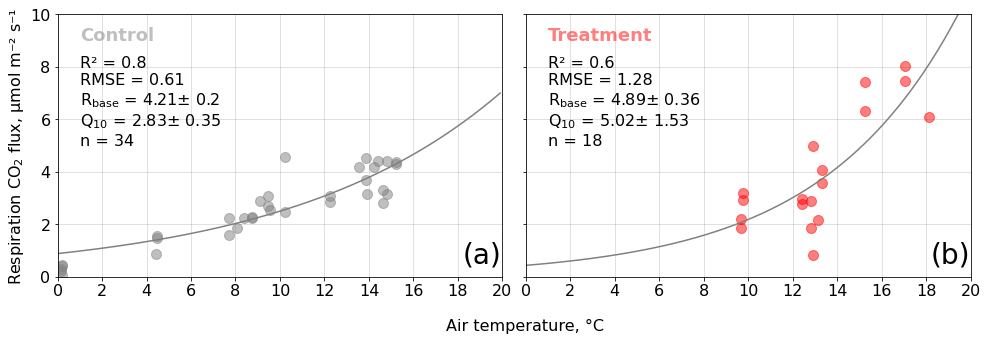

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.ticker as ticker


def Q10Model(T, Rbase, Q10):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10)    
    return FCO2mod # cannot give more than one return value in order for curve_fit to work

def RMSE(obs, pred):
    return np.sqrt((sum((obs-pred)**2))/len(obs))
    
font = dict(size=16)
matplotlib.rc('font', **font)

Rd_params = np.empty((2,2))
Rd_params_err = np.empty((2,2))
groups = ['AST', 'Treat']
clrs = ['gray', 'red']
titles = ['Control', 'Treatment']
panelnames = ['(a)','(b)']
i = groups[0]
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)
for idx, group in enumerate(groups):


    plots = Vero['ID'][Vero['ID'].str.contains(group)]
    date = Vero['Date'][Vero['ID'].str.contains(group)]
    Rd = Vero.loc[Vero['ID'].str.contains(group), 'FCO2 µmol m-2 s-1']
    T =  Vero.loc[Vero['ID'].str.contains(group), 'AirT']
    #clr_var = Vero.loc[Vero['ID'].str.contains(i), 'RH']
    #fltr = Vero.loc[Vero['ID'].str.contains(i), 'PAR µmol m-2 s-1']<20 & np.isfinite(Rd) & np.isfinite(T)
    fltr = np.logical_and(np.logical_and(Vero.loc[Vero['ID'].str.contains(group), 'PAR µmol m-2 s-1']<20,
                                         np.isfinite(Rd)
                                        ),
                          np.isfinite(T)
                         )
    Rd = Rd[fltr]
    T = T[fltr]

    
    ax[idx].plot(T, Rd, '.', color=clrs[idx], markersize=20, alpha=.5)

    popt, pcov = curve_fit(Q10Model, T, Rd, p0=[4, 2], bounds=([0, 0], [10, 10])) # rbase q10 
    perr = list(np.sqrt(np.diag(pcov)))
    
    Rd_opt = Q10Model(T, *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(Rd, Rd_opt)  
    ax[idx].plot(np.arange(0,20,.1), Q10Model(np.arange(0,20,.1), *popt), color='gray')
    ax[idx].set_xlim(0,20)
    ax[idx].set_ylim(0,10)
    ax[idx].grid(color='gray', alpha=.3)
    ax[idx].text(1, 5, f'R² = {round(r_value**2,1)}\n'
                       f'RMSE = {round(RMSE(Rd, Rd_opt),2)}\n'  
                       'R$_\mathrm{base}$ = '+f'{round(popt[0],2)}' + f'$\pm$ {round(perr[0],2)}\n'
                       'Q$_\mathrm{10}$ = '+f'{round(popt[1],2)}' + f'$\pm$ {round(perr[1],2)}\n'
                       f'n = {len(T)}')
    ax[idx].text(1, 9, titles[idx], color=clrs[idx], fontsize=18, fontweight='bold', alpha=.5)
    ax[idx].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax[idx].text(18.2,.5,panelnames[idx],fontsize=28)
    ax[0].set_ylabel('Respiration CO$_2$ flux, µmol m⁻² s⁻¹')
    Rd_params[idx,0] = popt[0]
    Rd_params[idx,1] = popt[1]
    Rd_params_err[idx, 0] = perr[0]
    Rd_params_err[idx, 1] = perr[1]
    
ax[0].set_xlabel('Air temperature, °C', x=1.05,labelpad=20)
fig.tight_layout(w_pad=0)
fig.savefig('Q10Model.png', dpi=300)
#f'{k} fit (R<sup>2</sup>={round(r_value**2,2)}) <br>\n' # <br> for html linebreak, \n to construct multiline fstring inclosed in ()
#f'R<sub>base</sub>: {round(popt[0],2)} &plusmn; {round(perr[0],2)} <br>\n'
#f'Q<sup>10</sup>: {round(popt[1],2)} &plusmn; {round(perr[1],2)}'

### __Stepwise bulk model, optimize Pmax, alpha__

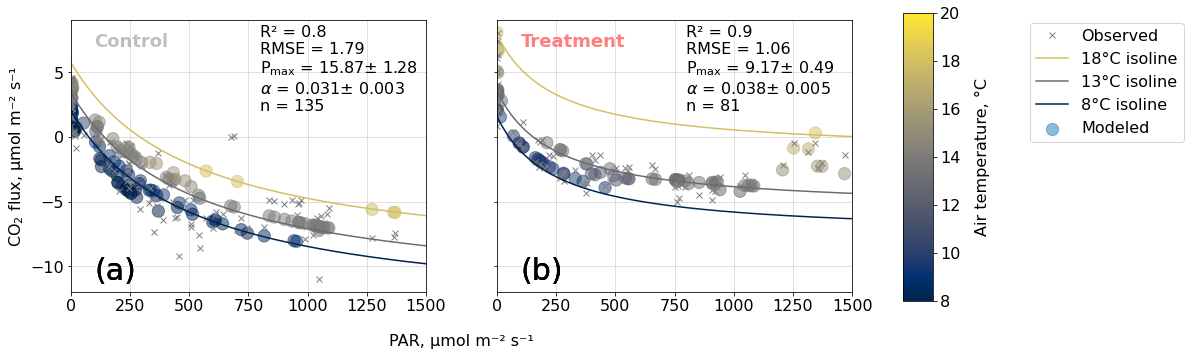

In [13]:
#%matplotlib widget
def LightSatModel(Indep, Pmax, alpha):
    (PAR, T, const) = Indep
    Tref = 15
    Rbase = const[0]
    Q10 = const[1]
    FCO2mod = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR)) + Rbase * Q10**((T-Tref)/10)    
    return FCO2mod
#del(fltr)
LightSat_params = np.empty((2,2))
LightSat_params_err = np.empty((2,2))
groups = ['AST', 'Treat']
#clrs = ['gray', 'red']
titles = ['Control', 'Treatment']
panelnames = ['(a)','(b)']
i = groups[0]
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)
for idx, group in enumerate(groups):


    FCO2 = Vero.loc[Vero['ID'].str.contains(group), 'FCO2 µmol m-2 s-1']
    PAR = Vero.loc[Vero['ID'].str.contains(group), 'PAR µmol m-2 s-1']
    T =  Vero.loc[Vero['ID'].str.contains(group), 'AirT']
    fltr = np.logical_and(np.logical_and(np.isfinite(FCO2),
                                         np.isfinite(PAR)
                                        ),
                          np.isfinite(T)
                         )
    FCO2 = FCO2[fltr]
    T = T[fltr]
    PAR = PAR[fltr]
    const = pd.Series([0]*len(PAR))
    const[:2] = Rd_params[idx,:]
    
    popt, pcov = curve_fit(LightSatModel,(PAR, T, const), FCO2, p0=[10, 0.04], bounds=([0, 0], [30, 1])) # pmax alpha
    perr = list(np.sqrt(np.diag(pcov)))    
    FCO2_opt = LightSatModel((PAR, T, const), *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(FCO2, FCO2_opt)
    mod_lne = ax[idx].scatter(PAR, FCO2_opt, c=T,
                       cmap='cividis',
                       s=150,
                       alpha=.5,
                       vmin=8,
                       vmax=20,
                       #edgecolors='face'
                        
                      )
    obs_lne = ax[idx].plot(PAR, FCO2,'x', color='gray')
    
    #ax[idx].plot(np.arange(0,20,.1), Q10Model(np.arange(0,20,.1), *popt), color='gray')
    ax[idx].set_xlim(0,1500)
    #ax[idx].set_ylim(0,10)
    ax[idx].grid(color='gray', alpha=.3)
    ax[idx].text(100, 7, titles[idx], color=clrs[idx], fontsize=18, fontweight='bold', alpha=.5)
    ax[idx].text(800, 2, f'R² = {round(r_value**2,1)}\n'
                         f'RMSE = {round(RMSE(FCO2, FCO2_opt),2)}\n'
                         'P$_\mathrm{max}$ = '+f'{round(popt[0],2)}' + f'$\pm$ {round(perr[0],2)}\n'
                         r'$\alpha$ = '+f'{round(popt[1],3)}' + f'$\pm$ {round(perr[1],3)}\n'
                         f'n = {len(T)}')
    LightSat_params[idx,0] = popt[0]
    LightSat_params[idx,1] = popt[1]
    LightSat_params_err[idx, 0] = perr[0]
    LightSat_params_err[idx, 1] = perr[1]
    
    
    isoline_T_groups = [18, 13, 8]
        # get color from colormap for specific value
    norm = matplotlib.colors.Normalize(vmin=8.0, vmax=20.0) # create matplotlib.colors.Normalize object to map colors in percent of range (previously set for colorbar)
    cmap = matplotlib.cm.get_cmap('cividis') # get cividis colormap

    for _,isoline_T in enumerate(isoline_T_groups):

        res = 1000

        #print(cmap(norm(14))) # evaluate normalized value for cividis, returns rgba
        isoline_xdata = np.linspace(0,1800,res)
        isoline_ydata = LightSatModel((pd.Series(np.linspace(0,1800,res)), pd.Series([isoline_T]*res), const), *popt)
        cmap(norm(isoline_T))[:3]
        ax[idx].plot(isoline_xdata, isoline_ydata, color=cmap(norm(isoline_T)))
        ax[idx].text(100,-11,panelnames[idx], fontsize=30)
            
            #fig.add_trace(go.Scatter(x=isoline_xdata,
            #                         y=isoline_ydata,
            #                         mode='lines',
            #                         marker=dict(color=f'rgb{cmap(norm(isoline_T))[:3]}',#pd.Series([isoline_T]*res),
    


cax = fig.add_axes([0.95, 0.1, 0.03, .8]) 
cbar = plt.colorbar(mod_lne, ax=ax[1], cax=cax)#, drawedges=False)
cbar.solids.set_alpha(1)
cbar.set_label('Air temperature, °C', labelpad=15)
ax[0].set_xlabel('PAR, µmol m⁻² s⁻¹', x=1.1,labelpad=20)
ax[0].set_ylabel('CO$_2$ flux, µmol m⁻² s⁻¹')

ax[1].legend(['Observed', '18°C isoline', '13°C isoline','8°C isoline','Modeled'],loc=(1.5,.55))


plt.savefig('BulkModel.png', dpi=300,bbox_inches = 'tight')


In [7]:
Vero

,ID,Date,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1,AirT,Timestamp_rounded,AirRH,PAR,SW_in,SW_out,LW_in,LW_out,NR01_T,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
Date,,,,,,,,,,,,,,,,,,
2018-01-23 19:23:28,AST1P1,23-Jan-2018 19:23:28,-9.2272,1.48210,457.5705,37.5160,9.57,2018-01-23 19:30:00,61.35,827.0,373.6084,75.5403,344.2315,360.7026,9.3961,0.0,4.188,252.5
2018-03-07 16:59:17,AST1P1,07-Mar-2018 16:59:17,-6.4570,0.94889,1035.4533,18.9374,13.93,2018-03-07 17:00:00,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:04:04,AST1P1,07-Mar-2018 17:04:04,-5.9518,0.86008,1083.4106,27.3755,13.93,2018-03-07 17:00:00,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:08:59,AST1P1,07-Mar-2018 17:08:59,-6.2376,0.91240,1038.3606,52.7387,13.93,2018-03-07 17:00:00,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:16:26,AST1P1,07-Mar-2018 17:16:26,-6.6604,0.98303,1068.9876,22.8582,13.85,2018-03-07 17:30:00,45.08,1634.0,714.3060,150.6247,293.2086,402.1044,15.2750,0.0,4.608,264.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-18 18:58:29,SPH3P3,18-Jan-2019 18:58:29,1.4522,0.35604,2.7473,6.1431,NaN,2019-01-18 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 18:28:58,SPH3P3,18-Jan-2019 18:28:58,-3.3655,0.53736,1184.5325,77.7921,NaN,2019-01-18 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 18:35:59,SPH3P3,18-Jan-2019 18:35:59,-3.0945,0.49870,1144.0790,23.0360,NaN,2019-01-18 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### __Cumulative C sum__

-249.93023649602696
4.813369004150409
-162.08722031836743
5.248376280969289
-274.8972517331106
5.244505208992345
-149.27969950003956
6.350985223052084


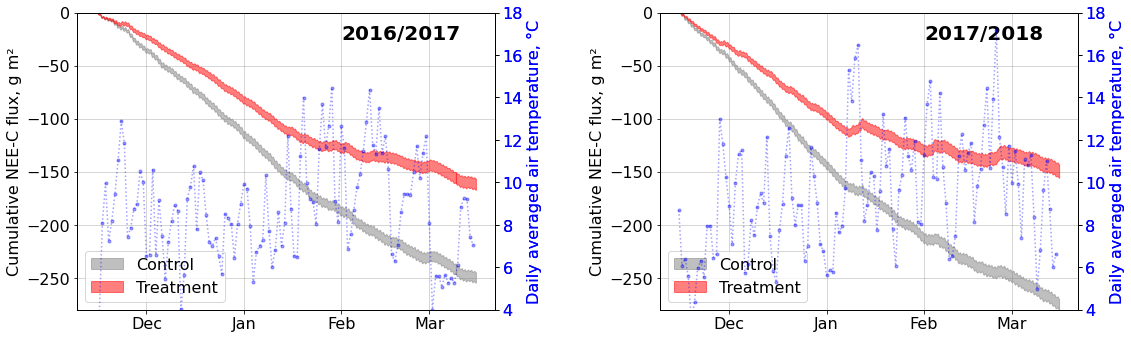

In [7]:
# 2016/2017 and 2017/2018
import matplotlib.dates as mdates
#AR_TF1.append(Biomet)['2018']['AirT_Avg'].plot()
#AR_TF1.append(Biomet)['PAR_Avg'].plot()
plt.close('all')

def GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax):
    err = 2*np.sqrt(
                   ((((alpha**2*PAR**2)/((Pmax+alpha*PAR)**2))**2)*u_Pmax**2) + 
                   ((((Pmax**2*PAR)/((Pmax+alpha*PAR)**2)**2))*u_alpha**2)
                   )
    return err

def TER_err(T, Q10, Rbase, u_Q10, u_Rbase):
    err = 2*np.sqrt((((Q10**((T-15)/10))**2)*u_Rbase**2)+
                    ((Rbase*((T-15)/10)*Q10**(((T-15)/10)-1))**2)*u_Q10**2
                   )    
    return err

def NEE_err(GPP_err, TER_err):
    err = 2*np.sqrt(GPP_err**2 + TER_err**2)
    return err

def NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10) -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    return FCO2mod

conversion = 60*30/1000000*12

fig, ax = plt.subplots(1,2, figsize=(16,5))

startyears = [2016, 2017]
colors = ['gray', 'red']

for idx, startyear in enumerate(startyears):

    T = AR_TF1.append(Biomet)[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['AirT_Avg']
    PAR = AR_TF1.append(Biomet)[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['PAR_Avg']

    for treat_flag in [0,1]:
        
        T_ax = ax[idx].twinx()
        T_ax.plot(T.resample('1D').mean().index,# - timedelta(days=3.5),
                  T.resample('1D').mean(),
                  marker='.',
                  linestyle=':',
                  alpha=.2,
                  color='b'                 
                 )
        T_ax.tick_params(axis='y', labelcolor='b')
        T_ax.set_ylim(4,18)
        T_ax.set_ylabel('Daily averaged air temperature, °C', color='b')

        Rbase = Rd_params[treat_flag][0]
        Q10 = Rd_params[treat_flag][1]
        u_Rbase = Rd_params_err[treat_flag][0]*2 # sqrt of diagonal of covariance matrix gives single standard deviation, times 2 here fro 95% confidence
        u_Q10 = Rd_params_err[treat_flag][1]*2
        Pmax = LightSat_params[treat_flag][0]
        alpha = LightSat_params[treat_flag][1]
        u_Pmax = LightSat_params_err[treat_flag][0]*2
        u_alpha = LightSat_params_err[treat_flag][1]*2

        upper = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) +
                 np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                            TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
                )

        lower = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) -
                 np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                            TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
                )

        ax[idx].fill_between(x=T.index, y1=lower, y2=upper, color=colors[treat_flag], alpha=.5,zorder=3)    
        print(np.nansum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion))
        print(np.sqrt(np.nansum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                   TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2)))

    months = mdates.MonthLocator()  # every month
    ax[idx].xaxis.set_major_locator(months)
    ax[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[idx].grid(color='gray',  alpha=.4)
    ax[idx].set_ylabel('Cumulative NEE-C flux, g m²')  #CO$\mathrm{_2}$-
    ax[idx].set_ylim(-280,0)
    ax[idx].text(pd.to_datetime(f'01-Feb-{startyear+1}'), -25, f'{startyear}/{startyear+1}', fontsize=20, fontweight='bold')
    ax[idx].legend(['Control','Treatment'], loc='lower left')
    
fig.tight_layout(w_pad=3)    

#fig.savefig('CumNEE_GrowingS.png', dpi=300)



In [14]:
# ATTENTION EXECUTE ONLY ONCE
# gf biomet table, DONT EXECUTE THIS TWICE, because of append
Biomet_1min_resampled = Biomet_1min.resample('30min').mean()
Biomet_1min_resampled['Rain_Tot'] = Biomet_1min['Rain_Tot'].resample('30min').sum()

Biomet_1min_resampled.index = Biomet_1min_resampled.index + timedelta(minutes=30)

Biomet = AR_TF1.append(Biomet)

Biomet = Biomet.loc[:'2019-01-18 06:00'].append(
                                                Biomet_1min_resampled.loc['2019-01-18 06:30' : '2019-03-25 14:00']).append(
                                                Biomet.loc['2019-03-25 14:00':])

Biomet

,AirT_Avg,AirRH_Avg,PAR_Avg,SW_in_Avg,SW_out_Avg,LW_in_Avg,LW_out_Avg,NR01_T_Avg,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
2016-01-31 18:30:00,14.0233,76.7510,1844.8571,966.91080,139.836600,295.6995,311.9690,15.451200,0.0,5.7895,123.0381
2016-01-31 19:00:00,13.7240,76.7687,1764.1000,924.04000,136.159600,293.8629,309.9835,15.269500,0.0,5.5837,125.4000
2016-01-31 19:30:00,13.4993,76.7917,1650.8333,863.46470,127.968900,292.9430,309.0135,15.045200,0.0,5.3114,130.8000
2016-01-31 20:00:00,13.4983,75.9137,1516.8333,793.51140,118.296300,292.2771,308.2670,15.117100,0.0,4.8691,131.7567
2016-01-31 20:30:00,13.5427,75.2247,1342.5333,701.90480,105.331200,292.6351,308.6681,15.082500,0.0,5.0338,136.4033
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30 13:00:00,1.9750,88.8000,99.7000,52.65601,6.681684,315.1697,323.6253,1.875236,0.0,8.8000,308.0000
2019-08-30 13:30:00,2.4730,87.2000,195.9000,105.54500,13.133600,314.6371,326.7234,2.419822,0.0,8.8000,308.0000
2019-08-30 14:00:00,3.3540,81.9000,279.3000,148.09740,19.063350,313.5920,330.8806,3.396524,0.0,8.8000,308.0000
2019-08-30 14:30:00,3.9660,75.6100,446.9000,228.70600,32.620650,284.9301,333.7900,4.256265,0.0,8.8000,308.0000


In [16]:
Biomet_1min_resampled.loc['2019-01-18 06:30' : '2019-03-25 14:00'].head(30)
#Biomet['Jan 2019'].to_csv('test.csv')

,AirT_Avg,AirRH_Avg,PAR_Avg,SW_in_Avg,SW_out_Avg,LW_in_Avg,LW_out_Avg,NR01_T_Avg,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
TIMESTAMP,,,,,,,,,,,
2019-01-18 06:30:00,8.300633,70.876333,0.068200,-2.545650,0.080455,315.742930,351.330897,9.294032,0.0,1.761833,250.936667
2019-01-18 07:00:00,7.311567,74.835000,0.054000,-3.801454,-0.807663,306.090363,341.317197,7.552954,0.0,1.154767,272.243367
2019-01-18 07:30:00,7.407500,78.196000,0.072500,-0.233264,0.533869,336.309947,346.586777,7.122545,0.0,1.748067,294.373000
2019-01-18 08:00:00,8.731133,71.388667,0.152833,-0.021746,0.682661,342.182310,351.098093,8.420929,0.0,1.648133,288.693333
2019-01-18 08:30:00,9.485000,72.164000,1.619000,-0.261842,0.175349,343.244010,354.926430,9.438256,0.0,2.101700,227.226667
2019-01-18 09:00:00,9.203667,73.709000,11.332200,2.924590,0.351987,339.298920,354.227053,9.270412,0.0,1.529333,218.370000
2019-01-18 09:30:00,8.897000,77.554667,44.434667,16.001947,2.377216,321.521627,353.040367,8.891567,0.0,2.261000,217.860000
2019-01-18 10:00:00,8.824000,79.378000,86.526333,35.592043,5.668265,322.896997,354.272740,8.877754,0.0,2.359700,205.923333
2019-01-18 10:30:00,8.780333,80.780333,75.701000,32.259707,5.306033,339.186827,355.832327,8.896725,0.0,0.930667,121.424000


-249.93023649602696
4.813369004150409
-162.08722031836743
5.248376280969289
-274.8972517331106
5.244505208992345
-149.27969950003956
6.350985223052084
-244.888081538212
4.812033318231594
-155.4558793731204
6.121844058432664


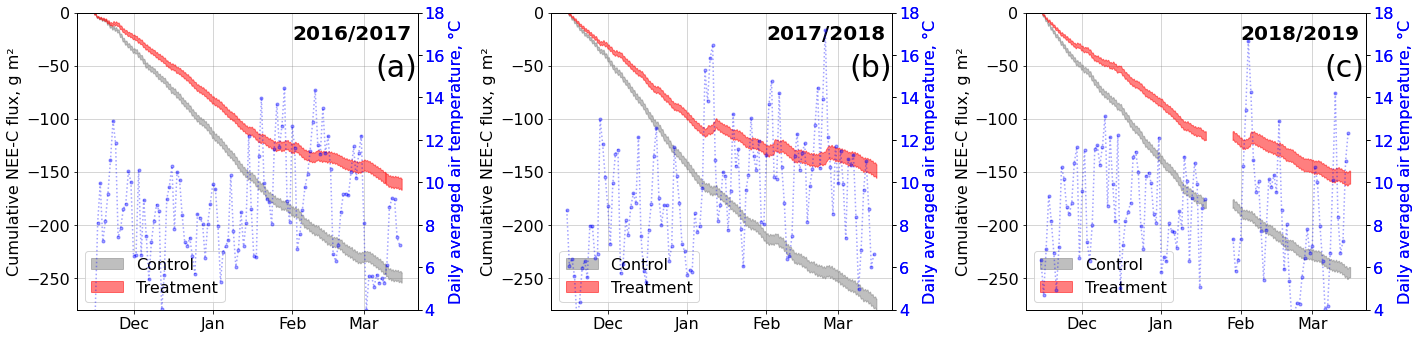

In [22]:
# 2016/2017 and 2017/2018 and 208/2019
import matplotlib.dates as mdates
#AR_TF1.append(Biomet)['2018']['AirT_Avg'].plot()
#AR_TF1.append(Biomet)['PAR_Avg'].plot()

plt.close('all')

def GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax):
    err = 2*np.sqrt(
                   ((((alpha**2*PAR**2)/((Pmax+alpha*PAR)**2))**2)*u_Pmax**2) + 
                   ((((Pmax**2*PAR)/((Pmax+alpha*PAR)**2)**2))*u_alpha**2)
                   )
    return err

def TER_err(T, Q10, Rbase, u_Q10, u_Rbase):
    err = 2*np.sqrt((((Q10**((T-15)/10))**2)*u_Rbase**2)+
                    ((Rbase*((T-15)/10)*Q10**(((T-15)/10)-1))**2)*u_Q10**2
                   )    
    return err

def NEE_err(GPP_err, TER_err):
    err = 2*np.sqrt(GPP_err**2 + TER_err**2)
    return err

def NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10) -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    return FCO2mod

conversion = 60*30/1000000*12

fig, ax = plt.subplots(1,3, figsize=(20,5))

startyears = [2016, 2017, 2018]
colors = ['gray', 'red']
panelnames = ['(a)','(b)','(c)']

for idx, startyear in enumerate(startyears):

    T = Biomet[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['AirT_Avg']
    PAR = Biomet[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['PAR_Avg']

    for treat_flag in [0,1]:
        
        T_ax = ax[idx].twinx()
        T_ax.plot(T.resample('1D').mean().index,# - timedelta(days=3.5),
                  T.resample('1D').mean(),
                  marker='.',
                  linestyle=':',
                  alpha=.2,
                  color='b'                 
                 )
        T_ax.tick_params(axis='y', labelcolor='b')
        T_ax.set_ylim(4,18)
        T_ax.set_ylabel('Daily averaged air temperature, °C', color='b')

        Rbase = Rd_params[treat_flag][0]
        Q10 = Rd_params[treat_flag][1]
        u_Rbase = Rd_params_err[treat_flag][0]*2 # sqrt of diagonal of covariance matrix gives single standard deviation, times 2 here fro 95% confidence
        u_Q10 = Rd_params_err[treat_flag][1]*2
        Pmax = LightSat_params[treat_flag][0]
        alpha = LightSat_params[treat_flag][1]
        u_Pmax = LightSat_params_err[treat_flag][0]*2
        u_alpha = LightSat_params_err[treat_flag][1]*2

        upper = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) +
                 np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                            TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
                )

        lower = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) -
                 np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                            TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
                )

        ax[idx].fill_between(x=T.index, y1=lower, y2=upper, color=colors[treat_flag], alpha=.5,zorder=3)    
        print(np.nansum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion))
        print(np.sqrt(np.nansum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                   TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2)))

    months = mdates.MonthLocator()  # every month
    ax[idx].xaxis.set_major_locator(months)
    ax[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[idx].grid(color='gray',  alpha=.4)
    ax[idx].set_ylabel('Cumulative NEE-C flux, g m²')  #CO$\mathrm{_2}$-
    ax[idx].set_ylim(-280,0)
    ax[idx].text(pd.to_datetime(f'01-Feb-{startyear+1}'), -25, f'{startyear}/{startyear+1}', fontsize=20, fontweight='bold')
    ax[idx].legend(['Control','Treatment'], loc='lower left')
    ax[idx].text(T.index[-500], -60, panelnames[idx], fontsize=30)
fig.tight_layout()#w_pad=3)    




fig.savefig('CumNEE_GrowingS_v2.png', dpi=300)



-174.34274698450955
6.00570634241881
-131.97317371920752
4.442907984520862
-216.49205771451435
6.145182161040176
-121.78361612540758
4.905919397020762
-173.2740082590656
5.838381511450137
-128.82002147360708
4.566906072097146


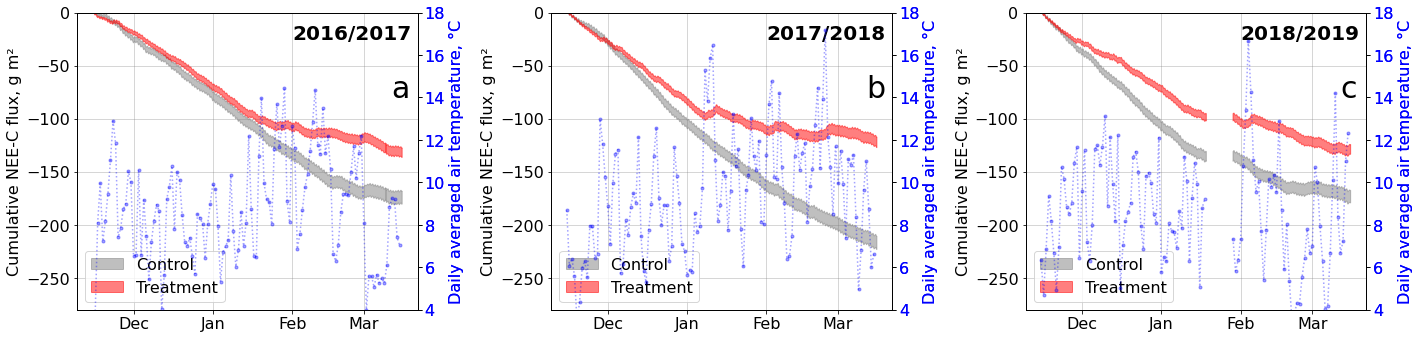

In [11]:
# cumulative NEE 2016/2017 and 2017/2018 and 208/2019 with 4-param bulk model results

import matplotlib.dates as mdates
#AR_TF1.append(Biomet)['2018']['AirT_Avg'].plot()
#AR_TF1.append(Biomet)['PAR_Avg'].plot()

plt.close('all')

def GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax):
    err = 2*np.sqrt(
                   ((((alpha**2*PAR**2)/((Pmax+alpha*PAR)**2))**2)*u_Pmax**2) + 
                   ((((Pmax**2*PAR)/((Pmax+alpha*PAR)**2)**2))*u_alpha**2)
                   )
    return err

def TER_err(T, Q10, Rbase, u_Q10, u_Rbase):
    err = 2*np.sqrt((((Q10**((T-15)/10))**2)*u_Rbase**2)+
                    ((Rbase*((T-15)/10)*Q10**(((T-15)/10)-1))**2)*u_Q10**2
                   )    
    return err

def NEE_err(GPP_err, TER_err):
    err = 2*np.sqrt(GPP_err**2 + TER_err**2)
    return err

def NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10) -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    return FCO2mod

conversion = 60*30/1000000*12

fig, ax = plt.subplots(1,3, figsize=(20,5))

startyears = [2016, 2017, 2018]
colors = ['gray', 'red']
panelnames = ['a','b','c']

for idx, startyear in enumerate(startyears):

    T = Biomet[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['AirT_Avg']
    PAR = Biomet[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['PAR_Avg']

    for treat_flag in [0,1]:
        
        T_ax = ax[idx].twinx()
        T_ax.plot(T.resample('1D').mean().index,# - timedelta(days=3.5),
                  T.resample('1D').mean(),
                  marker='.',
                  linestyle=':',
                  alpha=.2,
                  color='b'                 
                 )
        T_ax.tick_params(axis='y', labelcolor='b')
        T_ax.set_ylim(4,18)
        T_ax.set_ylabel('Daily averaged air temperature, °C', color='b')
        
        if treat_flag==0:
            Rbase = 2.96
            Q10 = 1.12
            u_Rbase = 0.32*2
            u_Q10 = 0.13*2
            Pmax = 12.81
            alpha = 0.038
            u_Pmax = 0.86*2
            u_alpha = 0.005*2
        if treat_flag==1:
            Rbase = 4.92
            Q10 = 3.65
            u_Rbase = 0.3*2
            u_Q10 = 0.64*2
            Pmax = 8.36
            alpha = 0.052
            u_Pmax = 0.46*2
            u_alpha = 0.011*2

        upper = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) +
                 np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                            TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
                )

        lower = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) -
                 np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                            TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
                )

        ax[idx].fill_between(x=T.index, y1=lower, y2=upper, color=colors[treat_flag], alpha=.5,zorder=3)    
        print(np.nansum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion))
        print(np.sqrt(np.nansum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                   TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2)))

    months = mdates.MonthLocator()  # every month
    ax[idx].xaxis.set_major_locator(months)
    ax[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[idx].grid(color='gray',  alpha=.4)
    ax[idx].set_ylabel('Cumulative NEE-C flux, g m²')  #CO$\mathrm{_2}$-
    ax[idx].set_ylim(-280,0)
    ax[idx].text(pd.to_datetime(f'01-Feb-{startyear+1}'), -25, f'{startyear}/{startyear+1}', fontsize=20, fontweight='bold')
    ax[idx].legend(['Control','Treatment'], loc='lower left')
    ax[idx].text(T.index[-200], -80, panelnames[idx], fontsize=30)
fig.tight_layout()#w_pad=3)
fig.savefig('CumNEE_GrowingS_v2_4param.png', dpi=300)

In [44]:
# impact of 4 param vs 2 param model on TER, treatment
def TER_Model(T, Rbase, Q10):
    Tref = 15
    TER = Rbase * Q10**((T-Tref)/10)
    return TER

startyears = [2016, 2017, 2018]
for startyear in startyears:
    T = Biomet[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['AirT_Avg']
    conversion = 60*30/1000000*12


    treat_flag = 1
    Rbase = Rd_params[treat_flag][0]
    Q10 = Rd_params[treat_flag][1]

    #TwoParam = np.nansum(TER_Model(T, Rbase, Q10))*conversion
    #FourParam = np.nansum(TER_Model(T, 4.92,3.65))*conversion

    TwoParam = TER_Model(T, Rbase, Q10)
    FourParam = TER_Model(T, 4.92,3.65)
    
    print(startyear)
    print('Average halfhourly ratio 4param/2param:')
    print(np.nanmean(FourParam/TwoParam))
    print('2parm sum')
    print(np.nansum(TwoParam)*conversion)
    print('4parm sum')
    print(np.nansum(FourParam)*conversion)
    print('Sum ratio 4param/2param')
    print((np.nansum(FourParam)*conversion)/(np.nansum(TwoParam)*conversion))



2016
Average halfhourly ratio 4param/2param:
1.2354968917309914
2parm sum
256.3955702652697
4parm sum
299.5545574736915
Sum ratio 4param/2param
1.168329691358431
2017
Average halfhourly ratio 4param/2param:
1.2093703664621536
2parm sum
301.7475911910744
4parm sum
338.56997684815946
Sum ratio 4param/2param
1.122030421226356
2018
Average halfhourly ratio 4param/2param:
1.2399695049497816
2parm sum
237.01668959560513
4parm sum
274.6504234048713
Sum ratio 4param/2param
1.1587809443861372


In [45]:
# impact of 4 param vs 2 param model on TER, control
def TER_Model(T, Rbase, Q10):
    Tref = 15
    TER = Rbase * Q10**((T-Tref)/10)
    return TER

startyears = [2016, 2017, 2018]
for startyear in startyears:
    T = Biomet[f'15 Nov {startyear}':f'15 Mar {startyear+1}']['AirT_Avg']
    conversion = 60*30/1000000*12


    treat_flag = 0
    Rbase = Rd_params[treat_flag][0]
    Q10 = Rd_params[treat_flag][1]

    #TwoParam = np.nansum(TER_Model(T, Rbase, Q10))*conversion
    #FourParam = np.nansum(TER_Model(T, 4.92,3.65))*conversion

    TwoParam = TER_Model(T, Rbase, Q10)
    FourParam = TER_Model(T, 2.96,1.12)
    
    print(startyear)
    print('Average halfhourly ratio 4param/2param:')
    print(np.nanmean(FourParam/TwoParam))
    print('2parm sum')
    print(np.nansum(TwoParam)*conversion)
    print('4parm sum')
    print(np.nansum(FourParam)*conversion)
    print('Sum ratio 4param/2param')
    print((np.nansum(FourParam)*conversion)/(np.nansum(TwoParam)*conversion))

2016
Average halfhourly ratio 4param/2param:
1.3130130045269048
2parm sum
290.90112842289074
4parm sum
345.90640651956596
Sum ratio 4param/2param
1.1890858189340283
2017
Average halfhourly ratio 4param/2param:
1.2429496774424464
2parm sum
319.3580997410832
4parm sum
348.98264525611705
Sum ratio 4param/2param
1.0927627811508513
2018
Average halfhourly ratio 4param/2param:
1.3302182257406876
2parm sum
265.71225037874564
4parm sum
315.9715115252688
Sum ratio 4param/2param
1.1891492058604138


In [17]:
AR_TF1.append(Biomet)['Jan 2019']

,AirT_Avg,AirRH_Avg,PAR_Avg,SW_in_Avg,SW_out_Avg,LW_in_Avg,LW_out_Avg,NR01_T_Avg,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
2019-01-01 00:00:00,7.592,90.00,38.780,19.032160,4.897324,347.7517,355.7722,7.717045,0.6,6.321,192.9
2019-01-01 00:30:00,6.489,86.80,17.880,7.238945,3.203886,337.7835,348.7543,6.523769,0.4,7.802,208.5
2019-01-01 01:00:00,6.165,85.80,4.244,0.523534,2.605813,333.8571,345.7480,6.039134,0.2,6.914,213.6
2019-01-01 01:30:00,5.714,83.10,1.115,-1.383430,2.000869,331.0010,344.3183,5.970835,0.0,6.178,222.3
2019-01-01 02:00:00,5.837,81.30,0.207,-1.724051,1.494175,333.0786,343.6949,5.952472,0.0,5.254,226.7
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-18 04:00:00,8.840,76.65,0.066,-3.374939,0.440887,295.6218,349.8146,8.656166,0.0,2.096,202.6
2019-01-18 04:30:00,7.565,78.58,0.065,-2.198067,0.646745,312.4107,349.3416,8.356387,0.0,1.889,218.0
2019-01-18 05:00:00,8.490,69.06,0.071,-2.408583,0.251978,313.1979,353.3423,9.561761,0.0,3.402,248.1
2019-01-18 05:30:00,8.460,68.34,0.067,-3.101713,0.190086,306.7940,351.3251,9.480334,0.0,2.651,261.4


### __Chamber vs EC model params__

In [33]:
ECParams = pd.read_csv('EC_ParamTS.csv')
ECParams.set_index(pd.to_datetime(ECParams['timestamp']), inplace=True)
ECParams.drop(columns='timestamp', inplace=True)
ECParams.loc[:,'Pmax_unc'] = 2.02
ECParams.loc[:,'alpha_unc'] = 0.005
ECParams.loc[:,'Rbase_unc'] = 0.64
ECParams.loc[:,'Q10_unc'] = 0.34

ECParams

,Pmax,alpha,Rbase,Q10,Pmax_unc,alpha_unc,Rbase_unc,Q10_unc
timestamp,,,,,,,,
2016-02-02,15.2171,0.029732,3.5839,1.3900,2.02,0.005,0.64,0.34
2016-02-03,15.1010,0.029615,3.5569,1.3911,2.02,0.005,0.64,0.34
2016-02-04,14.9848,0.029498,3.5300,1.3922,2.02,0.005,0.64,0.34
2016-02-05,14.8693,0.029381,3.5032,1.3933,2.02,0.005,0.64,0.34
2016-02-06,14.7537,0.029265,3.4765,1.3944,2.02,0.005,0.64,0.34
...,...,...,...,...,...,...,...,...
2018-05-12,5.2043,0.017872,1.7389,1.5052,2.02,0.005,0.64,0.34
2018-05-13,5.0391,0.017668,1.7086,1.5069,2.02,0.005,0.64,0.34
2018-05-14,4.8738,0.017465,1.6783,1.5086,2.02,0.005,0.64,0.34


In [34]:
MeasStats = pd.read_csv('NoChamberMeasPerDay.csv')
MeasStats['Date'] = pd.to_datetime(MeasStats['Date'])
MeasStats['Treatment']
MeasStats['Control']

0     11
1     24
2      0
3     24
4     26
5     11
6     16
7      0
8     15
9      8
10    18
Name: Control, dtype: int64

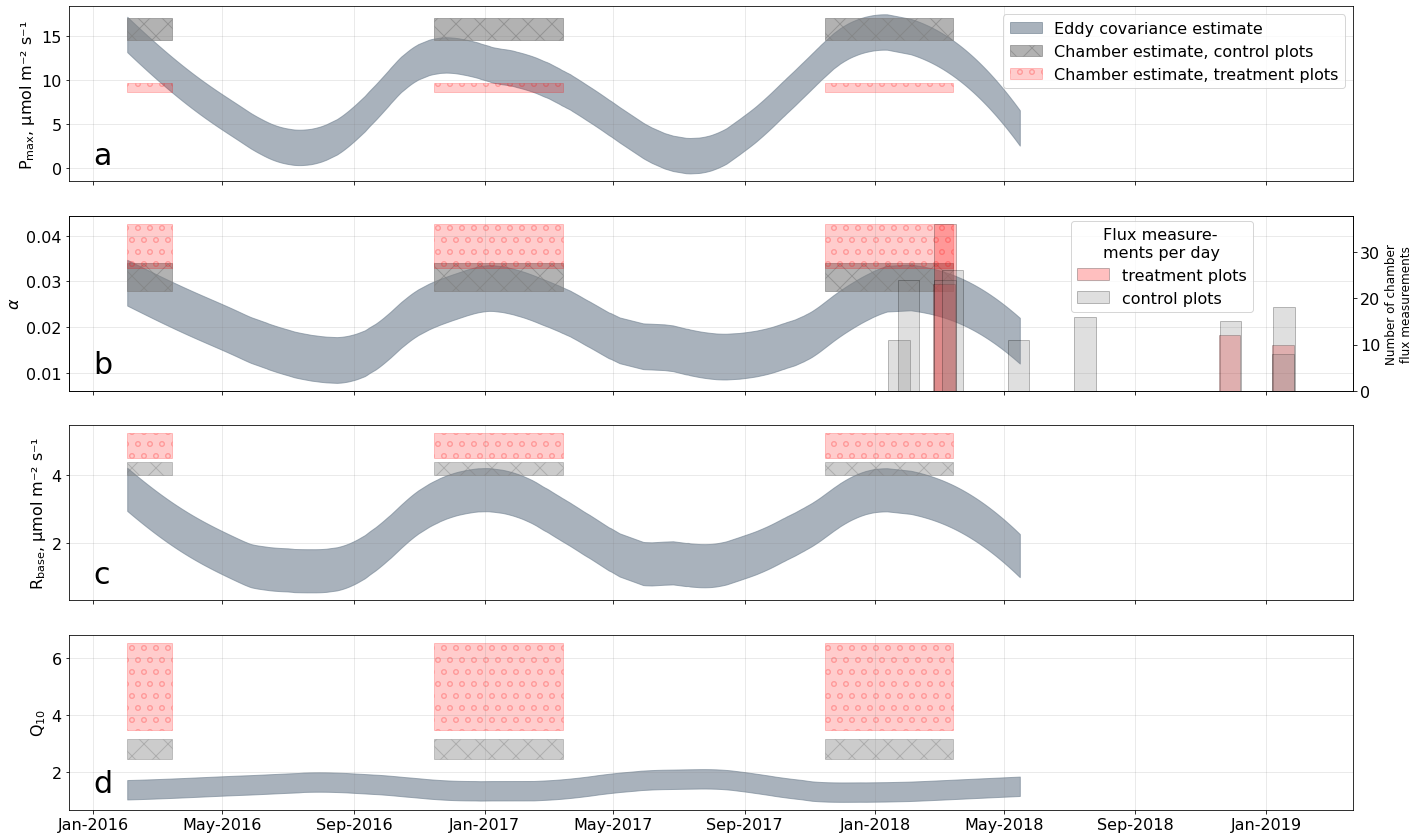

In [42]:


fig, ax = plt.subplots(4,1, figsize=(20,12), sharex=True)
lbl = ['P$_\mathrm{max}$, µmol m⁻² s⁻¹',
       r'$\alpha$',
       'R$_\mathrm{base}$, µmol m⁻² s⁻¹',
       'Q$_\mathrm{10}$']
panelnames = ['a','b','c','d']
for idx, col in enumerate(ECParams.columns[:4]):
    #ax[idx].plot(ECParams[col],'k')
    ax[idx].fill_between(x=ECParams.index,
                         y1=ECParams[col] + ECParams.iloc[:,idx+4],
                         y2=ECParams[col] - ECParams.iloc[:,idx+4],
                         color='slategrey',
                         alpha = .6
                        )
    for yr in [2015,2016,2017]:
        if idx==0 or idx==1:

            upper = [LightSat_params[0][idx] + LightSat_params_err[0][idx]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            lower = [LightSat_params[0][idx] - LightSat_params_err[0][idx]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            treat_chamb = ax[idx].fill_between(x=ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index,
                                               y1=upper,
                                               y2=lower,
                                               color='gray',
                                               alpha=.6,
                                               hatch='x'
                                              )
            upper = [LightSat_params[1][idx] + LightSat_params_err[1][idx]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            lower = [LightSat_params[1][idx] - LightSat_params_err[1][idx]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            ax[idx].fill_between(x=ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index,
                                 y1=upper,
                                 y2=lower,
                                 color='red',
                                 alpha=.2,
                                 hatch='o'
                                )
        elif idx==2 or idx==3:

            upper = [Rd_params[0][idx-2] + Rd_params_err[0][idx-2]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            lower = [Rd_params[0][idx-2] - Rd_params_err[0][idx-2]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            ax[idx].fill_between(x=ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index,
                                 y1=upper,
                                 y2=lower,
                                 color='gray',
                                 alpha=.4,
                                 hatch='x'
                                ) 
            upper = [Rd_params[1][idx-2] + Rd_params_err[1][idx-2]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            lower = [Rd_params[1][idx-2] - Rd_params_err[1][idx-2]]*len(ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index)
            ax[idx].fill_between(x=ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index,
                                 y1=upper,
                                 y2=lower,
                                 color='red',
                                 hatch='o',
                                 alpha=.2) 
    ax[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   
    ax[idx].grid(color='gray', alpha=.2)
    ax[idx].set_ylabel(lbl[idx])
    ax[idx].text(pd.to_datetime('Jan-2016'),
                 ax[idx].get_ylim()[0]+((ax[idx].get_ylim()[1]-ax[idx].get_ylim()[0])*.1),
                 panelnames[idx],
                 fontsize=30
                )
    if idx==1:
        meas_ax = ax[idx].twinx()
        meas_ax.bar(x=MeasStats['Date'],
                    height=MeasStats['Treatment'],
                    width=20,
                    color='red',
                    alpha=.25,
                    edgecolor='k',
                    #hatch='/'
                    )
        meas_ax.bar(x=MeasStats['Date'],
                    height=MeasStats['Control'],
                    #bottom=MeasStats['Treatment'], #stacked
                    width=20,
                    color='gray',
                    alpha=.25,
                    edgecolor='k',
                    #hatch='.'
                   )
        meas_ax.set_ylabel('Number of chamber\nflux measurements', fontsize=12)
        meas_ax.legend(['treatment plots', 'control plots'], title='Flux measure-\nments per day', loc=(.78, .45))
        
ax[0].legend(['Eddy covariance estimate', 'Chamber estimate, control plots', 'Chamber estimate, treatment plots'])


fig.tight_layout()        
fig.savefig('ECvsChamb_Params.png', dpi=300, bbox_inches = 'tight')

In [107]:
MeasStats['Date'][0]

Timestamp('2018-01-23 00:00:00')

In [127]:
yr=2016
ECParams[f'15 Nov {yr}':f'15 Mar {yr+1}'].index

DatetimeIndex(['2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10',
               ...
               '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-25',
               '2017-03-26', '2017-03-27', '2017-03-28', '2017-03-29',
               '2017-03-30', '2017-03-31'],
              dtype='datetime64[ns]', name='timestamp', length=121, freq=None)

In [118]:
# first try, a bit messy

%matplotlib widget
fig, ax = plt.subplots(4,1, figsize=(14,10), sharex=True)

for idx, col in enumerate(ECParams.columns):
    ax[idx].plot(ECParams[col])
    #ECParams[col].plot(ax=ax[idx])
    if idx==0 or idx==1:
        upper = pd.DataFrame([LightSat_params[0][idx] + LightSat_params_err[0][idx]]*len(ECParams.index), columns=['val'])
        upper.set_index(ECParams.index, inplace=True)
        lower = pd.DataFrame([LightSat_params[0][idx] - LightSat_params_err[0][idx]]*len(ECParams.index), columns=['val'])
        lower.set_index(ECParams.index, inplace=True)
        slice_idx = np.logical_or(upper.index.month==12, upper.index.month<=3)
        upper = upper.loc[slice_idx,'val'].values.tolist()
        lower = lower.loc[slice_idx,'val'].values.tolist()
        
        ax[idx].fill_between(x=ECParams[slice_idx].index,y1=upper, y2=lower, color='gray', alpha=.4, step='pre')
    elif idx==2 or idx==3:
        upper = pd.Series([Rd_params[0][idx-2] + Rd_params_err[0][idx-2]]*len(ECParams.index))
        lower = pd.Series([Rd_params[0][idx-2] - Rd_params_err[0][idx-2]]*len(ECParams.index))
        ax[idx].fill_between(x=ECParams.index,y1=upper,y2=lower, color='gray', alpha=.4)

#ax[0].plot(ECParams.index,lower)
#ax[0].plot(2,3)
#fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [115]:
len(upper)
len(ECParams[slice_idx])

301

In [ ]:
#list(upper)
upper = pd.DataFrame([LightSat_params[0][0] + LightSat_params_err[0][0]]*len(ECParams.index), columns=['val'])
upper.set_index(ECParams.index, inplace=True)
slice_idx = np.logical_or(upper.index.month==12, upper.index.month<=3)
upper.loc[slice_idx].values.tolist()

In [31]:
np.sqrt(sum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                     TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))

5.8028499413526164

In [59]:
#fig, ax = plt.subplots(1,1)
#ax.plot(Vero['FCO2 µmol m-2 s-1'],'.')


23

In [60]:
#
UnDays = Vero.index.strftime('%d-%b-%Y').unique()
MeasStats = pd.DataFrame(pd.to_datetime(UnDays))


for k, MeasDays in enumerate(UnDays):
    idx = Vero.index.strftime('%d-%b-%Y') == UnDays[k]
    MeasStats.loc[k,'Total #'] = sum(idx)
    MeasStats.loc[k,'Treatment #'] = sum(Vero.loc[idx, 'ID'].str.contains('Treat'))
    MeasStats.loc[k,'Control #'] = sum(Vero.loc[idx, 'ID'].str.contains('AST'))
    #MeasStats.loc[k,'Other #'] = sum(~Vero.loc[idx, 'ID'].str.contains('AST') & ~Vero.loc[idx, 'ID'].str.contains('Treat'))

MeasStats.sort_values(by='Date')
#MeasStats
#type(MeasStats['Date'].values)

#pd.to_datetime(MeasStats['Date'])

,Date,Total #,Treatment #,Control #
0,2018-01-23,23.0,0.0,11.0
5,2018-02-01,42.0,0.0,24.0
9,2018-03-06,23.0,23.0,0.0
1,2018-03-07,69.0,36.0,24.0
7,2018-03-14,45.0,0.0,26.0
4,2018-05-17,28.0,0.0,11.0
3,2018-07-16,16.0,0.0,16.0
10,2018-11-28,12.0,12.0,0.0
2,2018-11-29,33.0,0.0,15.0
6,2019-01-17,31.0,10.0,8.0


In [44]:
~Vero.loc[idx, 'ID'].str.contains('AST') & ~Vero.loc[idx, 'ID'].str.contains('Treat')

Date
2018-11-28 16:28:41    False
2018-11-28 16:54:11    False
2018-11-28 16:48:06    False
2018-11-28 17:00:56    False
2018-11-28 17:24:23    False
2018-11-28 17:45:23    False
2018-11-28 17:35:50    False
2018-11-28 17:52:04    False
2018-11-28 18:13:23    False
2018-11-28 18:18:25    False
2018-11-28 18:31:11    False
2018-11-28 18:08:17    False
Name: ID, dtype: bool

In [84]:
AR_TF1.resample('1W').mean()['Jan-2018']

,AirT_Avg,AirRH_Avg,PAR_Avg,SW_in_Avg,SW_out_Avg,LW_in_Avg,LW_out_Avg,NR01_T_Avg,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
Timestamp,,,,,,,,,,,
2018-01-07,7.310262,78.149643,389.267696,175.013463,35.361236,342.799502,347.929853,7.589201,0.087500,2.850330,191.075062
2018-01-14,12.800500,68.556042,429.090765,178.935311,36.446242,352.876590,369.277968,12.974976,0.070238,4.391958,262.215229
2018-01-21,10.520946,68.459286,480.829232,199.997667,40.037725,338.606089,359.802212,10.738352,0.073810,3.815116,236.383682
2018-01-28,9.818223,74.792589,377.791973,161.428651,33.094029,349.186822,355.241558,9.913952,0.075000,3.151789,226.550312


### __estimate Q10 from dark measurements, v7 version__

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from numpy.matlib import repmat
from scipy.optimize import curve_fit
import scipy.stats as stats

def Q10Model(T, Rbase, Q10):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10)    
    return FCO2mod # cannot give more than one return value in order for cure_fit to work

Microform = Vero['ID'].unique()
clr_var_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})

fig = go.FigureWidget(make_subplots(rows=4, cols=1))

# initialize color axis, https://plotly.com/python/builtin-colorscales/,
fig.layout.coloraxis=dict(colorscale='cividis', #cividis, viridis
                          cmin=8,
                          cmax=20,
                          colorbar=dict(y=.5,
                                        yanchor='bottom',
                                        x=1.35,
                                        len=.5,
                                        title='Air temp., °C',
                                        xpad=0,
                                        ypad=0
                                       )
                         ) 
counter = -1
for i in Microform:
    counter += 1
    
    if 'AST' in i and not 'Treat' in i:
        lgndgrp = 'AST'
        clr = 'blue'
        clr_var_groups['AST'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))
        subplot_row = 1
    elif 'Treat' in i:
        lgndgrp = 'Treat'
        clr = 'cyan'
        clr_var_groups['Treat'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                             
        subplot_row = 2
    elif 'DON' in i:
        lgndgrp = 'DON'
        clr = 'red'
        clr_var_groups['DON'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                                     
        subplot_row = 3
    elif 'SPH' in i:
        lgndgrp = 'SPH'
        clr = 'green'
        clr_var_groups['SPH'].append(Vero['AirT'][Vero['ID'].str.contains(i)])
        subplot_row = 4
        
    plots = Vero['ID'][Vero['ID'].str.contains(i)]
    date = Vero['Date'][Vero['ID'].str.contains(i)]
    Rd = Vero.loc[Vero['ID'].str.contains(i), 'FCO2 µmol m-2 s-1']
    T =  Vero.loc[Vero['ID'].str.contains(i), 'AirT']
    #clr_var = Vero.loc[Vero['ID'].str.contains(i), 'RH']
    fltr = Vero.loc[Vero['ID'].str.contains(i), 'PAR µmol m-2 s-1']>20
    Rd[fltr] = np.nan
    T[fltr] = np.nan
    #print(Rd)
    #'''
    
    fig.add_trace(go.Scatter(x=T,
                             y=Rd,
                             name = i,
                             text=plots + ' <br>' + date,
                             mode='markers', #'markers+lines'
                             marker=dict(color='black',
                                         size=20,
                                         #coloraxis='coloraxis',# share same coloraxis: https://plotly.com/python/reference/#scatter-marker-coloraxis
                                         opacity=.4), 
                             legendgroup=lgndgrp,
                            ),
                  row=subplot_row, col=1
                 )
    fig.data[counter].marker.symbol = counter+12 # markers can be called by their index/values, shift by 12 to get away from triangles
    #fig.update_layout(legend=dict(x=-0, y=1.2))

# plot fit to legendgroups
groups = ['AST', 'Treat', 'DON', 'SPH']
#groups = ['AST']


perr =  np.zeros((4,2))
counter = -1
rowIdx = [1,1,2,2]
colIdx = [1,2,1,2]
params = np.empty((4,2))
params_err = np.empty((4,2))
for k in groups:
    counter+=1

    group_idx = [i==k for i in [fig.data[i].legendgroup for i in range(len(fig.data))]]

    # see: list of lists..flat_list = [item for sublist in listoflists for item in sublist], listoflists = [list(i.x) for i in list(compress(fig.data, ast_idx))]
    T = pd.Series([item for sublist in [list(i.x) for i in list(compress(fig.data, group_idx))] for item in sublist]) # convert to pd.Series, curve_fit does not take pd.DataFrame
    FCO2 = pd.Series([item for sublist in [list(i.y) for i in list(compress(fig.data, group_idx))] for item in sublist]) 
    #clr_var = pd.Series(list(chain.from_iterable(clr_var_groups[k])))
    fltr = np.isfinite(FCO2) & np.isfinite(T)
    FCO2 = FCO2[fltr]
    T = T[fltr]
    #T.sort_values(inplace=True) # for continuous line
    print(len(FCO2))

    popt, pcov = curve_fit(Q10Model, T, FCO2, p0=[4, 2], bounds=([0, 0], [10, 10])) # rbase q10 
    perr = list(np.sqrt(np.diag(pcov)))

    FCO2_opt = Q10Model(T, *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(FCO2, FCO2_opt)    

    fig.add_trace(go.Scatter(x=np.arange(0,20,.1),
                             y=Q10Model(np.arange(0,20,.1), *popt),
                             name=(
                                   f'{k} fit (R<sup>2</sup>={round(r_value**2,2)}) <br>\n' # <br> for html linebreak, \n to construct multiline fstring inclosed in ()
                                   f'R<sub>base</sub>: {round(popt[0],2)} &plusmn; {round(perr[0],2)} <br>\n'
                                   f'Q<sup>10</sup>: {round(popt[1],2)} &plusmn; {round(perr[1],2)}'
                                   ), 
                             legendgroup=k,
                             mode='lines',
                            ),
                  row=counter+1, col=1
                 )
    #print(p_value)
    params[counter,0] = popt[0]
    params[counter,1] = popt[1]
    params_err[counter, 0] = perr[0]
    params_err[counter, 1] = perr[1]
fig.layout.legend.font.size = 16
fig.layout.font.size = 16
fig.layout.plot_bgcolor = 'rgba(0,0,0,.1)'
fig.layout.legend.tracegroupgap = 270
fig.update_layout(legend_itemclick=False)
fig.update_xaxes(range=[0,20], 
                 autorange=False,
                 title = 'T<sub>air</sub>, °C')
fig.update_yaxes(range=[0, 10],
                 autorange=False,
                 title='CO<sub>2</sub> flux, µmol m<sup>-2</sup>s<sup>-1</sup>')
fig.layout.height = 1800
fig.layout.width = 800
fig.update_layout(autosize = True)
#fig.show(renderer='iframe')
#'''

34
18
13
16


FigureWidget({
    'data': [{'legendgroup': 'AST',
              'marker': {'color': 'black', 'opacity': 0.4, …

### __2 parameter plot, v7 version__

In [10]:
# 2 parameter plot, fit pmax/alpha + residual scatter (mod vs meas + ColorVar)
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from numpy.matlib import repmat
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.cm

def LightSatModel(Indep, Pmax, alpha):
    (PAR, T, const) = Indep
    Tref = 15
    Rbase = const[0]
    Q10 = const[1]
    FCO2mod = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR)) + Rbase * Q10**((T-Tref)/10)    
    return FCO2mod

Microform = Vero['ID'].unique()
T_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
ClrVar_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
ClrVar_names = Vero.columns[8:-3]#['LW_in']

for ClrVar_name in ClrVar_names:
    T_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
    ClrVar_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
    
    if 'fig' in locals():
        del fig
    fig = go.FigureWidget(make_subplots(rows=4, cols=2))

    # initialize color axis, https://plotly.com/python/builtin-colorscales/,
    fig.layout.coloraxis=dict(colorscale='cividis', #cividis, viridis
                              cmin=8,
                              cmax=20,
                              colorbar=dict(y=.5,
                                            yanchor='bottom',
                                            x=-.45,
                                            len=.5,
                                            title='Air temp., °C',
                                            xpad=0,
                                            ypad=0
                                           )
                             ) 


    fig.layout.coloraxis2=dict(colorscale='viridis', #cividis, viridis
                               colorbar=dict(y=.5,
                                            yanchor='bottom',
                                            x=1.1,
                                            len=.5,
                                            title=f'{ClrVar_name}',
                                            xpad=0,
                                            ypad=0
                                           )
                             ) 
    counter = -1



    for i in Microform:
        counter += 1

        if 'AST' in i and not 'Treat' in i:
            lgndgrp = 'AST'
            clr = 'blue'
            T_groups['AST'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))
            ClrVar_groups['AST'].append(list(Vero[ClrVar_name][Vero['ID'].str.contains(i)].values))
            subplot_row = 1
        elif 'Treat' in i:
            lgndgrp = 'Treat'
            clr = 'cyan'
            T_groups['Treat'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))  
            ClrVar_groups['Treat'].append(list(Vero[ClrVar_name][Vero['ID'].str.contains(i)].values))
            subplot_row = 2
        elif 'DON' in i:
            lgndgrp = 'DON'
            clr = 'red'
            T_groups['DON'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))   
            ClrVar_groups['DON'].append(list(Vero[ClrVar_name][Vero['ID'].str.contains(i)].values))
            subplot_row = 3
        elif 'SPH' in i:
            lgndgrp = 'SPH'
            clr = 'green'
            T_groups['SPH'].append(Vero['AirT'][Vero['ID'].str.contains(i)])
            ClrVar_groups['SPH'].append(list(Vero[ClrVar_name][Vero['ID'].str.contains(i)].values))
            subplot_row = 4

        plots = Vero['ID'][Vero['ID'].str.contains(i)]
        date = Vero['Date'][Vero['ID'].str.contains(i)]
        fig.add_trace(go.Scatter(x=Vero['PAR µmol m-2 s-1'][Vero['ID'].str.contains(i)],
                                 y=Vero['FCO2 µmol m-2 s-1'][Vero['ID'].str.contains(i)],
                                 name = i,
                                 text=plots + ' <br>' + date,
                                 mode='markers', #'markers+lines'
                                 marker=go.scatter.Marker(size=15,
                                                         opacity=0.6,
                                                         color='black'), 
                                 legendgroup=lgndgrp,
                                ),
                      row=subplot_row, col=1
                     )
        fig.data[counter].marker.symbol = counter+12 # markers can be called by their index/values, shift by 12 to get away from triangles
        #fig.update_layout(legend=dict(x=-0, y=1.2))

    # plot fit to legendgroups
    groups = ['AST', 'Treat', 'DON', 'SPH']
    #groups = ['AST']


    perr =  np.zeros((4,2))
    LightSatParams = np.empty((4,2))
    LightSatParams_err = np.empty((4,2))

    
    counter = -1
    for k in groups:
        counter+=1

        group_idx = [i==k for i in [fig.data[i].legendgroup for i in range(len(fig.data))]]

        # see: list of lists..flat_list = [item for sublist in listoflists for item in sublist], listoflists = [list(i.x) for i in list(compress(fig.data, ast_idx))]
        PAR = pd.Series([item for sublist in [list(i.x) for i in list(compress(fig.data, group_idx))] for item in sublist]) # convert to pd.Series, curve_fit does not take pd.DataFrame
        FCO2 = pd.Series([item for sublist in [list(i.y) for i in list(compress(fig.data, group_idx))] for item in sublist]) 
        T = pd.Series(list(chain.from_iterable(T_groups[k])))
        ClrVar = pd.Series(list(chain.from_iterable(ClrVar_groups[k])))
        
        print(len(np.isfinite(FCO2))) # available fluxes
        
        fltr = np.isfinite(FCO2) & np.isfinite(PAR) & np.isfinite(T)
        PAR = PAR[fltr]
        FCO2 = FCO2[fltr]
        T = T[fltr]
        const = pd.Series([0]*len(PAR))
        const[:2] = params[counter,:]
        popt, pcov = curve_fit(LightSatModel,(PAR, T, const), FCO2, p0=[10, 0.04], bounds=([0, 0], [30, 1])) # pmax alpha
        perr = list(np.sqrt(np.diag(pcov)))
        #print(len(FCO2)) # available fluxes when PAR and T available

        FCO2_opt = LightSatModel((PAR, T, const), *popt)
        slope, intercept, r_value, p_value, std_err = stats.linregress(FCO2, FCO2_opt)    

        fig.add_trace(go.Scatter(x=PAR,
                                 y=LightSatModel((PAR, T, const), *popt),
                                 name=(
                                       f'{k} fit (R<sup>2</sup>={round(r_value**2,2)}) <br>\n' # <br> for html linebreak, \n to construct multiline fstring inclosed in ()
                                       f'P<sub>max</sub>: {round(popt[0],2)} &plusmn; {round(perr[0],2)} macht<br>\n'
                                       f'&#945; :{round(popt[1],3)} &plusmn; {round(perr[1],3)}<br>\n' #&alpha; does not work therefore &#945;
                                       f'R<sub>base</sub> fixed: {round(const[0],2)} <br>\n'
                                       f'Q<sup>10</sup> fixed: {round(const[1],2)}'
                                       ), 
                                 legendgroup=k,
                                 mode='markers',
                                 marker=dict(color=T,
                                             size=20,
                                             coloraxis='coloraxis',# share same coloraxis: https://plotly.com/python/reference/#scatter-marker-coloraxis
                                             opacity=.7
                                             )
                                ),
                      row=counter+1, col=1
                     )
        # add scatter in second column
        fig.add_trace(go.Scatter(x=FCO2,
                                 y=FCO2_opt,
                                 mode='markers',
                                 marker=dict(color=ClrVar,
                                             size=10,
                                             opacity=.5,
                                             coloraxis='coloraxis2'

                                            ),
                                 showlegend=False
                                ),
                      row=counter+1, col=2
                     )
        fig.add_trace(go.Scatter(x=[-10, 10],
                                 y=[-10, 10],
                                 mode='lines',
                                 showlegend=False,
                                 line=dict(color='gray')
                                ),
                      row=counter+1, col=2,

                     )

        LightSatParams[counter,0] = popt[0]
        LightSatParams[counter,1] = popt[1]
        LightSatParams_err[counter,0] = perr[0]
        LightSatParams_err[counter,1] = perr[1]
        
        isoline_T_groups = [18, 14, 8]
        # get color from colormap for specific value
        norm = matplotlib.colors.Normalize(vmin=8.0, vmax=20.0) # create matplotlib.colors.Normalize object to map colors in percent of range (previously set for colorbar)
        cmap = matplotlib.cm.get_cmap('cividis') # get cividis colormap

        for idx,isoline_T in enumerate(isoline_T_groups):
            #isoline_T = 15
            if k=='AST':
                legend_switch=True
            else:
                legend_switch=False
            res = 1000

            #print(cmap(norm(14))) # evaluate normalized value for cividis, returns rgba
            isoline_xdata = np.linspace(0,1800,res)
            isoline_ydata = LightSatModel((pd.Series(np.linspace(0,1800,res)), pd.Series([isoline_T]*res), const), *popt)
            fig.add_trace(go.Scatter(x=isoline_xdata,
                                     y=isoline_ydata,
                                     mode='lines',
                                     marker=dict(color=f'rgb{cmap(norm(isoline_T))[:3]}',#pd.Series([isoline_T]*res),
                                                 #coloraxis='coloraxis',
                                                 opacity=.8,
                                                 size=2,
                                                 #symbol='line-ns'
                                                 line=dict(#autocolorscale=False,                   # color formatting doesnt work on line, idk why
                                                           #cauto=False,
                                                           color=f'rgba{cmap(norm(isoline_T))}'#pd.Series([isoline_T]*res),
                                                           #colorscale='cividis',
                                                           #coloraxis='coloraxis'

                                                          )
                                                ),                                 
                                     legendgroup=k,
                                     name=f'{isoline_T}°C isoline',
                                     showlegend=legend_switch
                                    ),
                          row=counter+1, col=1)


        fig.layout.legend.font.size = 16

        fig.layout.font.size = 16

        # ||| affects all axes |||
        fig.update_xaxes(range=[0,1700], 
                         autorange=False,
                         title = 'PAR, µmol m<sup>-2</sup>s<sup>-1</sup>')
        fig.update_yaxes(range=[-12, 12],
                         autorange=False,
                         title='CO<sub>2</sub> flux, µmol m<sup>-2</sup>s<sup>-1</sup>')
        #del ClrVar_groups



    [fig.update_yaxes(range=[-12, 12],
                      autorange=False,
                      title='Modeled CO<sub>2</sub> flux, µmol m<sup>-2</sup>s<sup>-1</sup>',
                      row=kk, col=2,
                      tickvals=np.arange(-10,11,5),
                      side='right'
                     )
    for kk in range(1,5,1)]
    [fig.update_xaxes(range=[-12,12], 
                      autorange=False,
                      title = 'Observed CO<sub>2</sub> flux, µmol m<sup>-2</sup>s<sup>-1</sup>',
                      row=kk, col=2,
                      tickvals=np.arange(-10,11,5)
                    )
    for kk in range(1,5,1)]

    fig.layout.plot_bgcolor = 'rgba(0,0,0,.1)'
    fig.layout.legend.tracegroupgap = 210
    fig.layout.legend.x=-.35
    fig.layout.legend.y = 1
    #fig.layout.legend.itemsizing = 'constant' # sets marker size in legend to default and doesn't scale with trace size
    fig.update_layout(legend_itemclick=False)
    fig.layout.height = 1800

    fig.update_layout(autosize = True)
    #fig.show(renderer='png')
    #clear_output(wait=True)
    #fig.show()
    #with open('FCO2ModResidual_vs_'+ClrVar_name+'.html', 'a') as f:
    #    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

153
81
67
61
153
81
67
61
153
81
67
61
153
81
67
61
153
81
67
61
153
81
67
61
153
81
67
61


In [11]:
import matplotlib.pyplot as plt

Microform = Vero['ID'].unique()
T_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
Vero['GPP'] = np.zeros((len(Vero),1))

fig = go.FigureWidget(make_subplots(rows=2, cols=2))

# initialize color axis, https://plotly.com/python/builtin-colorscales/,
fig.layout.coloraxis=dict(colorscale='cividis', #cividis, viridis
                          cmin=5,
                          cmax=15,
                          colorbar=dict(y=0,
                                        yanchor='bottom',
                                        x=-.2,
                                        #len=.5,
                                        title='Air temp., °C',
                                        #xpad=0,
                                        #ypad=0
                                       )
                         ) 
counter = -1

for i in Microform:
    counter += 1
    
    if 'AST' in i and not 'Treat' in i:
        lgndgrp = 'AST'
        clr = 'blue'
        T_groups['AST'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))
        Pmax = LightSatParams[0,0]
        alpha = LightSatParams[0,1]
        subrow=1
        subcol=1
    elif 'Treat' in i:
        lgndgrp = 'Treat'
        clr = 'cyan'
        T_groups['Treat'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                             
        Pmax = LightSatParams[1,0]
        alpha = LightSatParams[1,1]
        subrow=1
        subcol=2
    elif 'DON' in i:
        lgndgrp = 'DON'
        clr = 'red'
        T_groups['DON'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                                     
        Pmax = LightSatParams[2,0]
        alpha = LightSatParams[2,1]
        subrow=2
        subcol=1
    elif 'SPH' in i:
        lgndgrp = 'SPH'
        clr = 'green'
        T_groups['SPH'].append(Vero['AirT'][Vero['ID'].str.contains(i)])
        Pmax = LightSatParams[3,0]
        alpha = LightSatParams[3,1]
        subrow=2
        subcol=2


    plots = Vero['ID'][Vero['ID'].str.contains(i)]
    date = Vero['Date'][Vero['ID'].str.contains(i)]
    PAR = Vero['PAR µmol m-2 s-1'][Vero['ID'].str.contains(i)]
    # calc GPP estimate from 2 param bulk model derived from 4 param model with Rb, Q10 fixed
    Vero.loc[Vero['ID'].str.contains(i), 'GPP'] = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))


    # calc Rd and GPP estimate
    #Vero.drop(columns='Rd', inplace=True)
    offset = 15 # 30 min around measurement
    par_thresh = 20
    
    Vero_slice = Vero[Vero['ID'].str.contains(i)]
    for idx,timestep in enumerate(Vero_slice.index):
        if Vero_slice.loc[timestep, 'PAR µmol m-2 s-1'] > par_thresh:
            start_idx = timestep - timedelta(minutes=offset) 
            end_idx = timestep + timedelta(minutes=offset)
            end_idx = end_idx.strftime('%d-%b-%Y %H:%M')
            start_idx = start_idx.strftime('%d-%b-%Y %H:%M')
            dark_index = Vero_slice.loc[start_idx:end_idx, 'PAR µmol m-2 s-1'] < par_thresh
            Vero.loc[timestep,'Rd'] = np.nanmean(Vero_slice.loc[start_idx:end_idx,'FCO2 µmol m-2 s-1'][dark_index])#.mean()
            Vero.loc[timestep,'Rd_N_Avg'] = np.isfinite(Vero_slice.loc[start_idx:end_idx,'FCO2 µmol m-2 s-1'][dark_index]).sum()

    Vero['GPP_Rd_est'] = Vero['FCO2 µmol m-2 s-1'] - Vero['Rd']
    xdata = Vero.loc[Vero['ID'].str.contains(i),'GPP']
    ydata = Vero.loc[Vero['ID'].str.contains(i),'GPP_Rd_est']
    
    
    # plot
    fig.add_trace(go.Scatter(x=xdata,
                             y=ydata,
                             name = i,
                             text=plots + ' <br>' + date,
                             mode='markers', #'markers+lines'
                             marker=go.scatter.Marker(size=15,
                                                     opacity=0.6,
                                                     color=Vero.loc[Vero['ID'].str.contains(i),'AirT'],
                                                     coloraxis='coloraxis'), 
                             legendgroup=lgndgrp,                             
                            ),
                  row=subrow, col=subcol
                 )
    fig.data[counter].marker.symbol = counter+12 # markers can be called by their index/values, shift by 12 to get away from triangles
    

    

    '''
    slope, intercept, r_value, p_value, std_err = stats.linregress(Vero['GPP'][fltr], Vero['GPP_Rd_est'][fltr])    

    ax.text(-11.7,-1.5,f'R²={round(r_value**2,3)} \n'
                   f'n={sum(fltr)}')

    
    '''
    
    fig.update_xaxes(range=[-12,0], 
                     autorange=False,
                     tickvals=np.arange(0,13,2)*-1
                    # title = 'Stepwise bulk model GPP estimate <br> GPP = f(PAR; Pmax,alpha )'
                    )
    fig.update_yaxes(range=[-12, 0],
                     autorange=False,
                    # title='Dark measurement GPP estimate <br> GPP = NEE<sub>meas</sub> - <SPAN STYLE="text-decoration:overline">R</SPAN><sub>d</sub>'
                    )
    #layout.xaxis.title

line_rows = [1,2,1,2]
line_cols = [1,1,2,2]
for line_row,line_col in zip(line_rows, line_cols):

    fig.add_trace(go.Scatter(x=[-12,0],
                             y=[-12,0],
                             mode='lines',
                             marker=dict(color='black'),
                             opacity=.4,
                             showlegend=False
                            ),
                  row=line_row, 
                  col=line_col,
                  
                 )
    
groups = ['AST', 'Treat', 'DON', 'SPH']

counter = -1
text_rows = [1,1,2,2]
text_cols = [1,2,1,2]
for kk,k in enumerate(groups):
    counter+=1

    group_idx = [i==k for i in [fig.data[i].legendgroup for i in range(len(fig.data))]]

    # see: list of lists..flat_list = [item for sublist in listoflists for item in sublist], listoflists = [list(i.x) for i in list(compress(fig.data, ast_idx))]
    BulkGPP = pd.Series([item for sublist in [list(i.x) for i in list(compress(fig.data, group_idx))] for item in sublist]) # convert to pd.Series, curve_fit does not take pd.DataFrame
    RdGPP = pd.Series([item for sublist in [list(i.y) for i in list(compress(fig.data, group_idx))] for item in sublist]) 
    fltr = np.isfinite(BulkGPP) & np.isfinite(RdGPP)
    RdGPP = RdGPP[fltr]
    BulkGPP = BulkGPP[fltr]
    slope, intercept, r_value, p_value, std_err = stats.linregress(BulkGPP, RdGPP) 
    
    
    # see: list of lists..flat_list = [item for sublist in listoflists for item in sublist], listoflists = [list(i.x) for i in list(compress(fig.data, ast_idx))]
    PAR = pd.Series([item for sublist in [list(i.x) for i in list(compress(fig.data, group_idx))] for item in sublist]) # convert to pd.Series, curve_fit does not take pd.DataFrame
    FCO2 = pd.Series([item for sublist in [list(i.y) for i in list(compress(fig.data, group_idx))] for item in sublist]) 
    T = pd.Series(list(chain.from_iterable(T_groups[k])))
    ClrVar = pd.Series(list(chain.from_iterable(ClrVar_groups[k])))
    fltr = np.isfinite(FCO2) & np.isfinite(PAR) & np.isfinite(T)
    PAR = PAR[fltr]
    FCO2 = FCO2[fltr]
    T = T[fltr]
    const = pd.Series([0]*len(PAR))
    const[:2] = params[counter,:]
    popt, pcov = curve_fit(LightSatModel,(PAR, T, const), FCO2, p0=[10, 0.04], bounds=([0, 0], [30, 1])) # pmax alpha
    perr = list(np.sqrt(np.diag(pcov)))
    
    
    
    print(r_value)
    fig.add_trace(go.Scatter(x=[-11], y=[-1.5],
                         text=k+'<br>'+'R<sup>2</sup> = '+str(round(r_value**2, 2)),
                         mode='text',
                         #fontsize=20,
                         showlegend=False
                        ),
              row=text_rows[kk], col=text_cols[kk]
             )

fig.layout.xaxis3.title = '&nbsp;'*100 +'Stepwise bulk model GPP estimate, GPP = f(PAR; Pmax,alpha)'    #add leading spaces to shift to middle of axis
fig.layout.yaxis3.title = '&nbsp;'*100 +'Dark measurement GPP estimate, GPP = NEE<sub>meas</sub> - <SPAN STYLE="text-decoration:overline">R</SPAN><sub>d</sub>'

fig.layout.plot_bgcolor = 'rgba(0,0,0,.1)'
#fig.layout.legend.tracegroupgap = 210
#fig.layout.legend.itemsizing = 'constant' # sets marker size in legend to default and doesn't scale with trace size
#fig.update_layout(legend_itemclick=False)
fig.layout.height = 800
fig.layout.width = 1100
fig.update_layout(autosize = True)    
#fig.tight_layout()
#fig.show(renderer='iframe') 

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



0.794072490653559
0.8372072895524615
0.8349098231237652
0.7569761984330801


FigureWidget({
    'data': [{'legendgroup': 'AST',
              'marker': {'color': array([ 9.57 , 13.93 , 13…

In [8]:
Vero.tail(20)


,ID,Date,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1,AirT,Timestamp_rounded,AirRH,PAR,SW_in,SW_out,LW_in,LW_out,NR01_T,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
Date,,,,,,,,,,,,,,,,,,
2019-01-18 16:40:16,SPH1P2,18-Jan-2019 16:40:16,-3.62360,0.558810,840.0930,79.5159,NaN,2019-01-18 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 17:23:17,SPH1P2,18-Jan-2019 17:23:17,-2.56060,0.435440,1132.0434,392.5297,NaN,2019-01-18 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 17:30:23,SPH1P2,18-Jan-2019 17:30:23,1.68250,0.279200,1.1629,3.1980,NaN,2019-01-18 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 17:08:34,SPH1P2,18-Jan-2019 17:08:34,-3.26270,0.522570,1231.6248,263.3001,NaN,2019-01-18 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14 20:51:11,SPH1P2,14-Mar-2018 20:51:11,-1.49920,0.244370,268.6204,112.3252,8.22,2018-03-14 21:00:00,67.50,451.6,223.9857,50.25930,307.9343,344.6687,8.23030,0.0,5.398,242.0
2019-01-17 17:03:08,SPH2P1,17-Jan-2019 17:03:08,-0.54621,0.119840,200.9957,57.6295,13.57,2019-01-17 17:00:00,55.97,1134.0,525.1799,91.74158,343.7193,403.0904,14.65963,0.0,5.754,265.8
2019-01-17 17:09:25,SPH2P1,17-Jan-2019 17:09:25,0.33361,0.061797,8.1909,16.1498,13.57,2019-01-17 17:00:00,55.97,1134.0,525.1799,91.74158,343.7193,403.0904,14.65963,0.0,5.754,265.8
2019-01-17 16:59:01,SPH2P1,17-Jan-2019 16:59:01,-1.36330,0.260030,341.2264,48.6558,13.57,2019-01-17 17:00:00,55.97,1134.0,525.1799,91.74158,343.7193,403.0904,14.65963,0.0,5.754,265.8
2019-01-17 16:54:34,SPH2P1,17-Jan-2019 16:54:34,-1.37930,0.215120,417.8879,58.4988,13.57,2019-01-17 17:00:00,55.97,1134.0,525.1799,91.74158,343.7193,403.0904,14.65963,0.0,5.754,265.8


In [17]:
print(params)
print(LightSatParams)
whos

[[4.20576996 2.82887999]
 [4.88557899 5.01532235]
 [3.57038894 2.29722345]
 [0.75735472 2.94575758]]
[[15.86821628  0.030925  ]
 [ 9.16916418  0.03780044]
 [14.16999735  0.0371414 ]
 [ 2.63709617  0.02296283]]


NameError: name 'whos' is not defined

In [52]:
AR_TF1.append(Biomet)['2018']['AirT_Avg'].plot()

In [55]:
AR_TF1.append(Biomet)['Dec-2017':'Feb-2018']['AirT_Avg']

2017-12-01 00:00:00     8.510
2017-12-01 00:30:00     7.912
2017-12-01 01:00:00     6.939
2017-12-01 01:30:00     5.112
2017-12-01 02:00:00     4.427
                        ...  
2018-02-28 21:30:00    14.310
2018-02-28 22:00:00    13.870
2018-02-28 22:30:00    13.660
2018-02-28 23:00:00    12.850
2018-02-28 23:30:00    12.030
Name: AirT_Avg, Length: 4320, dtype: float64

In [54]:
startyears = [2016,2017]
for idx, startyear in enumerate(startyears):
    print(idx)

0
1


In [47]:
%matplotlib widget
import matplotlib.dates as mdates
#AR_TF1.append(Biomet)['2018']['AirT_Avg'].plot()
#AR_TF1.append(Biomet)['PAR_Avg'].plot()

def GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax):
    err = 2*np.sqrt(
                   ((((alpha**2*PAR**2)/((Pmax+alpha*PAR)**2))**2)*u_Pmax**2) + 
                   ((((Pmax**2*PAR)/((Pmax+alpha*PAR)**2)**2))*u_alpha**2)
                   )
    return err

def TER_err(T, Q10, Rbase, u_Q10, u_Rbase):
    err = 2*np.sqrt((((Q10**((T-15)/10))**2)*u_Rbase**2)+
                    ((Rbase*((T-15)/10)*Q10**(((T-15)/10)-1))**2)*u_Q10**2
                   )    
    return err

def NEE_err(GPP_err, TER_err):
    err = 2*np.sqrt(GPP_err**2 + TER_err**2)
    return err

def NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10) -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    return FCO2mod

#T = AR_TF1.append(Biomet)['2018']['AirT_Avg']
#PAR = AR_TF1.append(Biomet)['2018']['PAR_Avg']
#T = AR_TF1.append(Biomet)['Dec-2017':'Feb-2018']['AirT_Avg']
#PAR = AR_TF1.append(Biomet)['Dec-2017':'Feb-2018']['PAR_Avg']

T = AR_TF1.append(Biomet)['Dec-2016':'Feb-2017']['AirT_Avg']
PAR = AR_TF1.append(Biomet)['Dec-2016':'Feb-2017']['PAR_Avg']


#T = AR_TF1.append(Biomet)['2017':'2018']['AirT_Avg']
#PAR = AR_TF1.append(Biomet)['2017':'2018']['PAR_Avg']
conversion = 60*30/1000000*12

#for treat_flag in [0,1]:

Rbase = params[0][0]
Q10 = params[0][1]
u_Rbase = params_err[0][0]
u_Q10 = params_err[0][1]
Pmax = LightSatParams[0][0]
alpha = LightSatParams[0][1]
u_Pmax = LightSatParams_err[0][0]
u_alpha = LightSatParams_err[0][1]

upper = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) +
         np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                    TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
        )

lower = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) -
         np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax),
                                    TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
        )

fig, ax = plt.subplots(1,1, figsize=(14,5))

ax.fill_between(x=T.index, y1=lower, y2=upper)    
    
    
#np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion).plot()


#Rbase = params[1][0]
#Q10 = params[1][1]
#Pmax = LightSatParams[1][0]
#alpha = LightSatParams[1][1]
#np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion).plot()#


Rbase = params[1][0]
Q10 = params[1][1]
u_Rbase = params_err[1][0]
u_Q10 = params_err[1][1]
Pmax = LightSatParams[1][0]
alpha = LightSatParams[1][1]
u_Pmax = LightSatParams_err[1][0]
u_alpha = LightSatParams_err[1][1]


upper = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) +
         np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax), TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
        )

lower = (np.cumsum(NEE_Model(T, PAR, Rbase, Q10, Pmax, alpha)*conversion) -
         np.sqrt(np.cumsum((NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax), TER_err(T, Q10, Rbase, u_Q10, u_Rbase))*conversion)**2))
        )

ax.fill_between(x=T.index, y1=lower, y2=upper)  

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
ax.grid(color='gray',  alpha=.4)
ax.set_ylabel('Cumulative CO$\mathrm{_2}$-C flux, g m²')




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Cumulative CO$\\mathrm{_2}$-C flux, g m²')

In [22]:
print(NEE_err(GPP_err(PAR, alpha, Pmax, u_alpha, u_Pmax), TER_err(T, Q10, Rbase, u_Q10, u_Rbase)))

None


In [24]:
TER_err(T, Q10, Rbase, u_Q10, u_Rbase)

2016-12-01 00:00:00    0.386069
2016-12-01 00:30:00    0.394339
2016-12-01 01:00:00    0.398039
2016-12-01 01:30:00    0.402322
2016-12-01 02:00:00    0.403177
                         ...   
2017-02-28 21:30:00    0.372859
2017-02-28 22:00:00    0.372547
2017-02-28 22:30:00    0.373173
2017-02-28 23:00:00    0.376381
2017-02-28 23:30:00    0.378336
Name: AirT_Avg, Length: 4320, dtype: float64

In [71]:
'''
2*np.sqrt(
          ((((alpha^2*PAR^2)/((Pmax+alpha*PAR)^2))^2)*u_Pmax^2) + 
          ((((Pmax^2*PAR)/((Pmax+alpha*PAR)^2)^2))*u_alpha^2)
         )
'''
#((((alpha^2*PAR^2)/((Pmax+alpha*PAR)^2))^2)*u_Pmax^2)
alpha^2*PAR^2

TypeError: Cannot perform 'rxor' with a dtyped [float64] array and scalar of type [bool]

In [60]:
np.sqrt(4)

2.0

In [50]:
conversion

0.07919999999999999

In [10]:
# remove AST from AST_Treat_XX for easier grouping, ATTENTION: repeated calls dont work
names = Vero.ID[Vero.ID.str.contains('Treat')].str.split('_')
Vero.loc[Vero.ID.str.contains('Treat'), 'ID'] = [' '.join(names[i][1:]) for i in range(len(names))]

In [27]:
# trad vs. bulk,
import matplotlib.pyplot as plt

def GPP_Model(PAR, Pmax, alpha):
    FCO2mod = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    return FCO2mod




Microform = Vero['ID'].unique()
T_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
Vero['GPP'] = np.zeros((len(Vero),1))

fig = go.FigureWidget(make_subplots(rows=2, cols=2))

# initialize color axis, https://plotly.com/python/builtin-colorscales/,
fig.layout.coloraxis=dict(colorscale='cividis', #cividis, viridis
                          cmin=5,
                          cmax=15,
                          colorbar=dict(y=0,
                                        yanchor='bottom',
                                        x=-.2,
                                        #len=.5,
                                        title='Air temp., °C',
                                        #xpad=0,
                                        #ypad=0
                                       )
                         ) 
counter = -1

for i in Microform:
    counter += 1
    
    if 'AST' in i and not 'Treat' in i:
        lgndgrp = 'AST'
        clr = 'blue'
        T_groups['AST'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))
        Pmax = LightSatParams[0,0]
        alpha = LightSatParams[0,1]
        Rbase = params[0][0]
        Q10 = params[0][1]
        subrow=1
        subcol=1
    elif 'Treat' in i:
        lgndgrp = 'Treat'
        clr = 'cyan'
        T_groups['Treat'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                             
        Pmax = LightSatParams[1,0]
        alpha = LightSatParams[1,1]
        Rbase = params[1][0]
        Q10 = params[1][1]
        subrow=1
        subcol=2
    elif 'DON' in i:
        lgndgrp = 'DON'
        clr = 'red'
        T_groups['DON'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                                     
        Pmax = LightSatParams[2,0]
        alpha = LightSatParams[2,1]
        Rbase = params[2][0]
        Q10 = params[2][1]
        subrow=2
        subcol=1
    elif 'SPH' in i:
        lgndgrp = 'SPH'
        clr = 'green'
        T_groups['SPH'].append(Vero['AirT'][Vero['ID'].str.contains(i)])
        Pmax = LightSatParams[3,0]
        alpha = LightSatParams[3,1]
        Rbase = params[3][0]
        Q10 = params[3][1]
        subrow=2
        subcol=2


    plots = Vero['ID'][Vero['ID'].str.contains(i)]
    date = Vero['Date'][Vero['ID'].str.contains(i)]
    PAR = Vero['PAR µmol m-2 s-1'][Vero['ID'].str.contains(i)]
    T = Vero['AirT'][Vero['ID'].str.contains(i)]
    Tref = 15
    
    # calc GPP estimate from 2 param bulk model derived from 4 param model with Rb, Q10 fixed
    Vero.loc[Vero['ID'].str.contains(i), 'GPP'] = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    Vero.loc[Vero['ID'].str.contains(i), 'Reco'] = Rbase * Q10**((T-Tref)/10)        


    # calc dark measurement Rd average per plot
    offset = 15 # 30 min around measurement
    par_thresh = 20
    
    Vero_slice = Vero[Vero['ID'].str.contains(i)]
    for idx,timestep in enumerate(Vero_slice.index):
        if Vero_slice.loc[timestep, 'PAR µmol m-2 s-1'] > par_thresh:
            start_idx = timestep - timedelta(minutes=offset) 
            end_idx = timestep + timedelta(minutes=offset)
            end_idx = end_idx.strftime('%d-%b-%Y %H:%M')
            start_idx = start_idx.strftime('%d-%b-%Y %H:%M')
            dark_index = Vero_slice.loc[start_idx:end_idx, 'PAR µmol m-2 s-1'] < par_thresh
            Vero.loc[timestep,'Rd'] = np.nanmean(Vero_slice.loc[start_idx:end_idx,'FCO2 µmol m-2 s-1'][dark_index])#.mean()
            Vero.loc[timestep,'Rd_N_Avg'] = np.isfinite(Vero_slice.loc[start_idx:end_idx,'FCO2 µmol m-2 s-1'][dark_index]).sum()

Vero['GPP_Rd_est'] = Vero['FCO2 µmol m-2 s-1'] - Vero['Rd']

groups = ['AST', 'Treat', 'DON', 'SPH']

subrows = [1,1,2,2]
subcols = [1,2,1,2]
for kk,k in enumerate(groups):
    
    if kk==0:
        lgnd_switch = True 
    else:
        lgnd_switch = False 

    GPP_Rd_est = Vero.loc[Vero.ID.str.contains(k), 'GPP_Rd_est']
    PAR = Vero.loc[Vero.ID.str.contains(k), 'PAR']
    fltr = ~np.isnan(PAR) & ~np.isnan(GPP_Rd_est)    
    popt, pcov = curve_fit(GPP_Model,PAR[fltr],
                           GPP_Rd_est[fltr],
                           p0=[10, 0.04],
                           bounds=([0, 0], [100, 1])
                          ) 
    perr = list(np.sqrt(np.diag(pcov)))    
    
    GPP_opt = GPP_Model(PAR[fltr], *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(GPP_Rd_est[fltr], GPP_opt)    
    

    # plot GPP_opt from traditional GPP estimate
    fig.add_trace(go.Scatter(x=np.arange(0,2000,.1),
                             y=GPP_Model(np.arange(0,2000,.1), *popt),
                             name=(f' <b>{k}</b><br>'
                                   f'Traditional dark model (R<sup>2</sup>={round(r_value**2,2)})<br>\n' # <br> for html linebreak, \n to construct multiline fstring inclosed in ()
                                   f'P<sub>max</sub>: {round(popt[0],2)} &plusmn; {round(perr[0],2)}<br>\n'
                                   f'alpha: {round(popt[1],3)} &plusmn; {round(perr[1],3)}<br>'
                                   ), 
                             legendgroup=k,
                             mode='lines',
                             marker=dict(color='gray')
                            ),
                  row=subrows[kk], col=subcols[kk]
                 )
    Pmax = LightSatParams[kk][0]
    alpha = LightSatParams[kk][1]

#    if kk==0:
#        lgnd_switch = True
#    else:
#        lgnd_switch = False

    
    
    # plot bulk model GPP estimate
    fig.add_trace(go.Scatter(x=np.arange(0,2000,.1),
                             y=-((Pmax*alpha*np.arange(0,2000,.1))/(Pmax+alpha*np.arange(0,2000,.1))),
                             legendgroup=k,
                             mode='lines',
                             name=f'Stepwise bulk model<br>' 
                                  f'P<sub>max</sub>: {round(Pmax,2)}<br>'
                                  f'alpha: {round(alpha,4)}<br>',
                             line=dict(color='red',
                                       dash='dot'
                                        ),
                             showlegend=True
                            ),
                  row=subrows[kk], col=subcols[kk]
                 )
    
     
    # plot NEEobs - Reco(bulk)
    fig.add_trace(go.Scatter(x=Vero.loc[Vero.ID.str.contains(k), 'PAR µmol m-2 s-1'],
                             y=Vero.loc[Vero.ID.str.contains(k), 'FCO2 µmol m-2 s-1'] - Vero.loc[Vero.ID.str.contains(k), 'Reco'],
                             legendgroup=k,
                             mode='markers',
                             name='NEE<sub>obs</sub> - Reco<sub>bulk</sub> ',
                             marker=dict(color='red',
                                         opacity=.4),
                             showlegend=lgnd_switch
                             
                            ),
                   row=subrows[kk], col=subcols[kk]
                 )
    # plot dark model GPPest
    fig.add_trace(go.Scatter(x=Vero.loc[Vero.ID.str.contains(k), 'PAR µmol m-2 s-1'],
                             y=Vero.loc[Vero.ID.str.contains(k), 'GPP_Rd_est'],
                             legendgroup=k,
                             mode='markers',
                             marker=go.scatter.Marker(symbol='circle',
                                                  size=15,
                                                  opacity=0.6,
                                                  color=Vero.loc[Vero.ID.str.contains(k), 'AirT'],
                                                  coloraxis='coloraxis'), 
                             showlegend=lgnd_switch,
                             name='GPP<sub>dark</sub> = NEE<sub>meas</sub> - <SPAN STYLE="text-decoration:overline">R</SPAN><sub>d</sub>'
                        ),
               row=subrows[kk], col=subcols[kk]
             )
    
    
    
    fig.add_trace(go.Scatter(x=[1800], y=[-2],
                             text=k,
                             mode='text',
                             textfont=dict(size=20),
                             showlegend=False),
                   row=subrows[kk], col=subcols[kk]
                 )
                 
                 

fig.layout.xaxis3.title = '&nbsp;'*100 +'PAR µmol m<sup>-2</sup> s<sup>-1</sup>'    #add leading spaces to shift to middle of axis
fig.layout.yaxis3.title = '&nbsp;'*100 +'GPP estimate, µmol m<sup>-2</sup> 1<sup>-1</sup>'

fig.layout.plot_bgcolor = 'rgba(0,0,0,.1)'
fig.layout.legend.tracegroupgap = 50
fig.layout.legend.font = dict(size=14)
#fig.layout.legend.itemsizing = 'constant' # sets marker size in legend to default and doesn't scale with trace size
#fig.update_layout(legend_itemclick=False)
fig.layout.height = 800
fig.layout.width = 1100
fig.update_layout(autosize = True)    
fig.update_yaxes(range=(-15,0))

fig.show(renderer='iframe') 


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning:

Mean of empty slice



In [26]:
fig.layout.legend.font = dict(size=20)

In [12]:
# trad vs. bulk, maybe too complicated version? see above
import matplotlib.pyplot as plt

def GPP_Model(PAR, Pmax, alpha):
    FCO2mod = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    return FCO2mod

Microform = Vero['ID'].unique()
T_groups = dict({'AST':[], 'Treat':[], 'DON':[], 'SPH':[]})
Vero['GPP'] = np.zeros((len(Vero),1))

fig = go.FigureWidget(make_subplots(rows=2, cols=2))

# initialize color axis, https://plotly.com/python/builtin-colorscales/,
fig.layout.coloraxis=dict(colorscale='cividis', #cividis, viridis
                          cmin=5,
                          cmax=15,
                          colorbar=dict(y=0,
                                        yanchor='bottom',
                                        x=-.2,
                                        #len=.5,
                                        title='Air temp., °C',
                                        #xpad=0,
                                        #ypad=0
                                       )
                         ) 
counter = -1

for i in Microform:
    counter += 1
    
    if 'AST' in i and not 'Treat' in i:
        lgndgrp = 'AST'
        clr = 'blue'
        T_groups['AST'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))
        Pmax = LightSatParams[0,0]
        alpha = LightSatParams[0,1]
        Rbase = params[0][0]
        Q10 = params[0][1]
        subrow=1
        subcol=1
    elif 'Treat' in i:
        lgndgrp = 'Treat'
        clr = 'cyan'
        T_groups['Treat'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                             
        Pmax = LightSatParams[1,0]
        alpha = LightSatParams[1,1]
        Rbase = params[1][0]
        Q10 = params[1][1]
        subrow=1
        subcol=2
    elif 'DON' in i:
        lgndgrp = 'DON'
        clr = 'red'
        T_groups['DON'].append(list(Vero['AirT'][Vero['ID'].str.contains(i)].values))                                     
        Pmax = LightSatParams[2,0]
        alpha = LightSatParams[2,1]
        Rbase = params[2][0]
        Q10 = params[2][1]
        subrow=2
        subcol=1
    elif 'SPH' in i:
        lgndgrp = 'SPH'
        clr = 'green'
        T_groups['SPH'].append(Vero['AirT'][Vero['ID'].str.contains(i)])
        Pmax = LightSatParams[3,0]
        alpha = LightSatParams[3,1]
        Rbase = params[3][0]
        Q10 = params[3][1]
        subrow=2
        subcol=2


    plots = Vero['ID'][Vero['ID'].str.contains(i)]
    date = Vero['Date'][Vero['ID'].str.contains(i)]
    PAR = Vero['PAR µmol m-2 s-1'][Vero['ID'].str.contains(i)]
    T = Vero['AirT'][Vero['ID'].str.contains(i)]
    Tref = 15
    
    # calc GPP estimate from 2 param bulk model derived from 4 param model with Rb, Q10 fixed
    Vero.loc[Vero['ID'].str.contains(i), 'GPP'] = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR))
    Vero.loc[Vero['ID'].str.contains(i), 'Reco'] = Rbase * Q10**((T-Tref)/10)    
    


    # calc Rd and GPP estimate
    #Vero.drop(columns='Rd', inplace=True)
    offset = 15 # 30 min around measurement
    par_thresh = 20
    
    Vero_slice = Vero[Vero['ID'].str.contains(i)]
    for idx,timestep in enumerate(Vero_slice.index):
        if Vero_slice.loc[timestep, 'PAR µmol m-2 s-1'] > par_thresh:
            start_idx = timestep - timedelta(minutes=offset) 
            end_idx = timestep + timedelta(minutes=offset)
            end_idx = end_idx.strftime('%d-%b-%Y %H:%M')
            start_idx = start_idx.strftime('%d-%b-%Y %H:%M')
            dark_index = Vero_slice.loc[start_idx:end_idx, 'PAR µmol m-2 s-1'] < par_thresh
            Vero.loc[timestep,'Rd'] = np.nanmean(Vero_slice.loc[start_idx:end_idx,'FCO2 µmol m-2 s-1'][dark_index])#.mean()
            Vero.loc[timestep,'Rd_N_Avg'] = np.isfinite(Vero_slice.loc[start_idx:end_idx,'FCO2 µmol m-2 s-1'][dark_index]).sum()

    
    xdata = Vero.loc[Vero['ID'].str.contains(i),'PAR']
    #ydata = Vero.loc[Vero['ID'].str.contains(i),'GPP_Rd_est']
    ydata = Vero.loc[Vero['ID'].str.contains(i),'FCO2 µmol m-2 s-1'] - Vero.loc[Vero['ID'].str.contains(i),'Rd']
    
    
    # plot
    fig.add_trace(go.Scatter(x=xdata,
                             y=ydata,
                             name = i,
                             text=plots + ' <br>' + date,
                             mode='markers', #'markers+lines'
                             marker=go.scatter.Marker(symbol='circle',
                                                      size=15,
                                                      opacity=0.6,
                                                      color=Vero.loc[Vero['ID'].str.contains(i),'AirT'],
                                                      coloraxis='coloraxis'), 
                             legendgroup=lgndgrp,
                             showlegend=False
                            ),
                  row=subrow, col=subcol
                 )
    #fig.data[counter].marker.symbol = counter+12 # markers can be called by their index/values, shift by 12 to get away from triangles
    
    

Vero['GPP_Rd_est'] = Vero['FCO2 µmol m-2 s-1'] - Vero['Rd']

groups = ['AST', 'Treat', 'DON', 'SPH']

#counter = -1
subrows = [1,1,2,2]
subcols = [1,2,1,2]
for kk,k in enumerate(groups):
    #counter+=1

    group_idx = [i==k for i in [fig.data[i].legendgroup for i in range(len(fig.data))]]   
    PAR = pd.Series([item for sublist in [list(i.x) for i in list(compress(fig.data, group_idx))] for item in sublist]) # convert to pd.Series, curve_fit does not take pd.DataFrame
    GPP_Rd_est = pd.Series([item for sublist in [list(i.y) for i in list(compress(fig.data, group_idx))] for item in sublist]) 
    fltr = ~np.isnan(PAR) & ~np.isnan(GPP_Rd_est)    
    popt, pcov = curve_fit(GPP_Model,PAR[fltr],
                           GPP_Rd_est[fltr],
                           p0=[10, 0.04],
                           bounds=([0, 0], [100, 1])
                          ) 
    perr = list(np.sqrt(np.diag(pcov)))    
    
    GPP_opt = GPP_Model(PAR[fltr], *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(GPP_Rd_est[fltr], GPP_opt)    
    
    # plot GPP_opt from traditional GPP estimate
    fig.add_trace(go.Scatter(x=np.arange(0,2000,.1),
                             y=GPP_Model(np.arange(0,2000,.1), *popt),
                             name=(
                                   f'{k} fit (R<sup>2</sup>={round(r_value**2,2)}) <br>\n' # <br> for html linebreak, \n to construct multiline fstring inclosed in ()
                                   f'P<sub>max</sub>: {round(popt[0],2)} &plusmn; {round(perr[0],2)} <br>\n'
                                   f'alpha: {round(popt[1],2)} &plusmn; {round(perr[1],2)}'
                                   ), 
                             legendgroup=k,
                             mode='lines',
                             marker=dict(color='gray')
                            ),
                  row=subrows[kk], col=subcols[kk]
                 )
    Pmax = LightSatParams[kk][0]
    alpha = LightSatParams[kk][1]

#    if kk==0:
#        lgnd_switch = True
#    else:
#        lgnd_switch = False

    
    
    # plot bulk model GPP estimate
    fig.add_trace(go.Scatter(x=np.arange(0,2000,.1),
                             y=-((Pmax*alpha*np.arange(0,2000,.1))/(Pmax+alpha*np.arange(0,2000,.1))),
                             legendgroup=k,
                             mode='lines',
                             name=f'GPP<sub>bulk</sub> <br>' 
                                  f'(Pmax={round(Pmax,2)}, alpha={round(alpha,4)})',
                             line=dict(color='red',
                                       dash='dot'
                                        ),
                             showlegend=True#lgnd_switch
                            ),
                  row=subrows[kk], col=subcols[kk]
                 )
    
    
    
    
    
    fig.add_trace(go.Scatter(x=Vero.loc[Vero.ID.str.contains(k), 'PAR µmol m-2 s-1'],
                             y=Vero.loc[Vero.ID.str.contains(k), 'FCO2 µmol m-2 s-1'] - Vero.loc[Vero.ID.str.contains(k), 'Reco'],
                             legendgroup=k,
                             mode='markers',
                             name='NEE<sub>obs</sub> - Reco<sub>bulk</sub> ',
                             marker=dict(color='red',
                                         opacity=.4),
                             showlegend=True#lgnd_switch
                             
                            ),
                   row=subrows[kk], col=subcols[kk]
                 )
    
    
    
    fig.add_trace(go.Scatter(x=[1800], y=[-2],
                             text=k,
                             mode='text',
                             textfont=dict(size=20),
                             showlegend=False),
                   row=subrows[kk], col=subcols[kk]
                 )
                 
                 

fig.layout.xaxis3.title = '&nbsp;'*100 +'PAR µmol m<sup>-2</sup> s<sup>-1</sup>'    #add leading spaces to shift to middle of axis
fig.layout.yaxis3.title = '&nbsp;'*100 +'Dark measurement GPP estimate, GPP = NEE<sub>meas</sub> - <SPAN STYLE="text-decoration:overline">R</SPAN><sub>d</sub>'

fig.layout.plot_bgcolor = 'rgba(0,0,0,.1)'
fig.layout.legend.tracegroupgap = 50
#fig.layout.legend.itemsizing = 'constant' # sets marker size in legend to default and doesn't scale with trace size
#fig.update_layout(legend_itemclick=False)
fig.layout.height = 800
fig.layout.width = 1100
fig.update_layout(autosize = True)    
fig.update_yaxes(range=(-15,0))
#fig.show(renderer='iframe') 


/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning:

Mean of empty slice



FigureWidget({
    'data': [{'legendgroup': 'AST',
              'marker': {'color': array([ 9.57 , 13.93 , 13…

In [101]:
Vero

,ID,Date,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1,AirT,Timestamp_rounded,AirRH,PAR,...,LW_out,NR01_T,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT,GPP,Rd,Rd_N_Avg,GPP_Rd_est,Reco
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-23 19:23:28,AST1P1,23-Jan-2018 19:23:28,-9.2272,1.48210,457.5705,37.5160,9.57,2018-01-23 19:30:00,61.35,827.0,...,360.7026,9.3961,0.0,4.188,252.5,-7.480070,NaN,0.0,NaN,2.391216
2018-03-07 16:59:17,AST1P1,07-Mar-2018 16:59:17,-6.4570,0.94889,1035.4533,18.9374,13.93,2018-03-07 17:00:00,41.61,1647.0,...,402.7068,15.4464,0.0,4.168,255.6,-10.610285,NaN,0.0,NaN,3.762901
2018-03-07 17:04:04,AST1P1,07-Mar-2018 17:04:04,-5.9518,0.86008,1083.4106,27.3755,13.93,2018-03-07 17:00:00,41.61,1647.0,...,402.7068,15.4464,0.0,4.168,255.6,-10.768225,NaN,0.0,NaN,3.762901
2018-03-07 17:08:59,AST1P1,07-Mar-2018 17:08:59,-6.2376,0.91240,1038.3606,52.7387,13.93,2018-03-07 17:00:00,41.61,1647.0,...,402.7068,15.4464,0.0,4.168,255.6,-10.620138,NaN,0.0,NaN,3.762901
2018-03-07 17:16:26,AST1P1,07-Mar-2018 17:16:26,-6.6604,0.98303,1068.9876,22.8582,13.85,2018-03-07 17:30:00,45.08,1634.0,...,402.1044,15.2750,0.0,4.608,264.6,-10.721732,NaN,0.0,NaN,3.731727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-18 18:58:29,SPH3P3,18-Jan-2019 18:58:29,1.4522,0.35604,2.7473,6.1431,NaN,2019-01-18 19:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.061612,NaN,NaN,NaN,NaN
2019-01-18 18:28:58,SPH3P3,18-Jan-2019 18:28:58,-3.3655,0.53736,1184.5325,77.7921,NaN,2019-01-18 18:30:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.404023,NaN,0.0,NaN,NaN
2019-01-18 18:35:59,SPH3P3,18-Jan-2019 18:35:59,-3.0945,0.49870,1144.0790,23.0360,NaN,2019-01-18 18:30:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.396534,NaN,0.0,NaN,NaN


In [91]:
Vero['GPP']
Vero['R']

Date
2018-01-23 19:23:28        NaN
2018-03-07 16:59:17        NaN
2018-03-07 17:04:04        NaN
2018-03-07 17:08:59        NaN
2018-03-07 17:16:26        NaN
                        ...   
2019-01-18 18:58:29        NaN
2019-01-18 18:28:58        NaN
2019-01-18 18:35:59        NaN
2019-01-18 18:44:05    1.56795
2019-01-18 18:51:59        NaN
Name: Rd, Length: 362, dtype: float64